# Natural Language Processing Capstone

### Using NLP to cluster and classify speeches by U.S. presidents

The leaders of the United States have a duty and an obligation to their people to convey how they are operating for this country. And with each leader comes another type of speech, voice, and flavor of their language. This can be a result of multiple factors -- where they are originally from, the time in which they live, or just things associated to their personality. With Natural Language Processing, we are able to analyze and show their words in different ways. With the ability to quantify their speeches and to then possible distinguish one type of use of language from another just shows how much potential this has for our future in this and many other technologies.

Using a corpus of U.S. Presidential speeches, we will attempt to cluster and classify speeches by president who gave them. The data is collected and curated by D.W. Brown, who compiled hundreds of speeches by the presidents and made them available online at: http://www.thegrammarlab.com/?nor-portfolio=corpus-of-presidential-speeches-cops-and-a-clintontrump-corpus.

For our project, we will be tackling just 10 of the 44 available presidents on Brown's website. This could potentially be done with more than 10, but I believe it might end up either taking too much processing time or perhaps just be completely unreadable with steps I am taking. To determine the best document-term matrix for clustering by president, we've decided to employ the use of Bag of Words as well as tf-idf. We will evaluate these document-term matrices after applying k-means clustering using the Adjusted Rand Index (ARI) as our scoring metric. After this, we will then use various clustering algorithms to determine which one is best at clustering our training data by president. Then, once the best combination of document-term matrix and clustering algorithm is achieved, we will cluster the data and hopefully classify it as much as possible. After determining the best classifier, we use the data then to predict the test dataset. And after all of this, we will compare the best clustering algorithm and best classifier by its performance on the entire dataset.

In [33]:
# Importing packages

import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
from collections import Counter
import nltk
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans, KMeans, MeanShift
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import estimate_bandwidth, SpectralClustering, AffinityPropagation
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import time
sns.set_style("white")
import en_core_web_sm
nlp = en_core_web_sm.load()

# Loading the Data

Each of our presidents' speeches are text files. We will see here if we have significant class imbalance such as some presidents having far more speeches than others. Also each file will need to be cleaned and converted into a document used by spaCy. Once they are in spaCy format, we are able to answer more questions with that data, such as word usage, lemma, and parts of speech.

In [40]:

# Importing the files from the database that we will analyze. 

# Barack Obama
# 2009 - 2017
obama_files = []
for filename in glob.glob('Corpus of Presential Speeches/obama/*.txt'): 
    file = open(filename, 'r')
    obama_files.append(file.read())
    file.close() 

# G. W. Bush    
# 2001 - 2009
gwbush_files = []    
for filename in glob.glob('Corpus of Presential Speeches/gwbush/*.txt'): 
    file = open(filename, 'r')
    gwbush_files.append(file.read())
    file.close() 

# Bill Clinton    
# 1993 - 2001
clinton_files = []   
for filename in glob.glob('Corpus of Presential Speeches/clinton/*.txt'): 
    file = open(filename, 'r')
    clinton_files.append(file.read())
    file.close()     

# J. F. Kennedy    
# 1961 - 1963
kennedy_files = []
for filename in glob.glob('Corpus of Presential Speeches/kennedy/*.txt'): 
    file = open(filename, 'r')
    kennedy_files.append(file.read())
    file.close()  

# F. D. Roosevelt    
# 1933 - 1945   
fdroosevelt_files = []    
for filename in glob.glob('Corpus of Presential Speeches/fdroosevelt/*.txt'): 
    file = open(filename, 'r')
    fdroosevelt_files.append(file.read())
    file.close() 

# Ulysses S. Grant    
# 1869 - 1877
grant_files = []
for filename in glob.glob('Corpus of Presential Speeches/grant/*.txt'): 
    file = open(filename, 'r')
    grant_files.append(file.read())
    file.close()     

# Andrew Johnson    
# 1865 - 1869    
johnson_files = []
for filename in glob.glob('Corpus of Presential Speeches/johnson/*.txt'): 
    file = open(filename, 'r')
    johnson_files.append(file.read())
    file.close()


# Andrew Jackson    
# 1829 - 1837
jackson_files = []
for filename in glob.glob('Corpus of Presential Speeches/jackson/*.txt'): 
    file = open(filename, 'r')
    jackson_files.append(file.read())
    file.close()     

# Thomas Jefferson    
# 1801 - 1809    
jefferson_files = []
for filename in glob.glob('Corpus of Presential Speeches/jefferson/*.txt'): 
    file = open(filename, 'r')
    jefferson_files.append(file.read())
    file.close() 

# George Washington    
# 1789 - 1797
washington_files = []   
for filename in glob.glob('Corpus of Presential Speeches/washington/*.txt'): 
    file = open(filename, 'r')
    washington_files.append(file.read())
    file.close()

With this next portion, we will see if certain presidents have more speeches than others in this corpus.

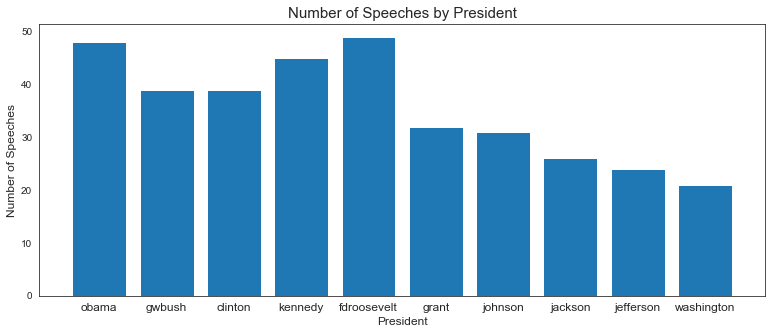

Exact Number of Speeches by President
48 obama
39 gwbush
39 clinton
45 kennedy
49 fdroosevelt
32 grant
31 johnson
26 jackson
24 jefferson
21 washington

Total Number of Speeches: 354


In [41]:
# creating a dictionary of presidents in this order
pres_dict = {0:'obama',
             1:'gwbush',
             2:'clinton', 
             3:'kennedy',
             4:'fdroosevelt',
             5:'grant',
             6:'johnson',
             7:'jackson',
             8:'jefferson',
             9:'washington'}

# creating a list of president names in this order
presidents = list(pres_dict.values())

# creating a list where each element is a list of a president's files.
all_uncleaned_files_by_president = [obama_files, gwbush_files, clinton_files, 
                          kennedy_files, fdroosevelt_files,
                          grant_files, johnson_files, jackson_files, jefferson_files,
                          washington_files]

# looping through each president to get a list of the number of speeches per president
number_of_speeches_list = [len(all_uncleaned_files_by_president[president_number])
             for president_number in range(len(all_uncleaned_files_by_president))]

plt.figure(figsize = (13,5))
plt.bar(height = number_of_speeches_list, x = presidents)
plt.title('Number of Speeches by President', fontsize = 15)
plt.ylabel('Number of Speeches', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

print('Exact Number of Speeches by President')
for index, president in enumerate(presidents):
    print(number_of_speeches_list[index], presidents[index])
    
print('\nTotal Number of Speeches: {}'.format(np.sum(number_of_speeches_list)))

Class imbalance does not seem to be much of an issue with our data. Our president with the least amount of speeches is Washington, who has just a little less than half than that of F.D. Roosevelt, the president with the greatest number of speeches. This group also has good overage of time periods, ranging both before and after 1900. We could also do a word count per president, but for the sake of consistency, we will just tally them according to speeches rather than word count and use that for our training and test data modeling.

If you read a little bit about the data, the curator of the data has tagged any words spoken within the speech by anyone other than the president with '<' and '>'. For example: 
- <LEHRER: Mr. Vice President, a rebuttal.>
- <BUSH: > Well, I don’t question his passion. I question — and I don’t question his concern about the war in Vietnam.
Knowing this, we can just remove anything between those markers.

After cleaning the data, we will convert each cleaned text file into a spaCy document.

In [43]:
# cleaning and rewriting files
# removing anything within < >

def text_cleaner(text):
    
    '''
    This function will take a string of text as an input
    
    It will then return that same string without instances of '--' and
    anything enclosed by '<' and '>'.
    '''
    
    # identify a form of punctuation spaCy doesn't recognize
    # and removing anything between < and >
    text = re.sub(r'--',' ',text)
    text = re.sub("[<].*?[>]","",text)
    text = ' '.join(text.split())
    return text

# loop through each of the files and applying the text_cleaner function 
all_cleaned_files_by_president = []
for index, president_files in enumerate(all_uncleaned_files_by_president):
    all_cleaned_files_for_this_president = []
    all_cleaned_files_by_president.append(all_cleaned_files_for_this_president)
    for file in president_files:
        all_cleaned_files_for_this_president.append(text_cleaner(file))

# renaming all_cleaned_files_by_president simply all_files_by_president
all_files_by_president = all_cleaned_files_by_president        
  

# looping through each cleaned file and converting it to a spacy doc.  
all_docs_by_president = []
for index, president_file in enumerate(all_files_by_president):
    all_docs_for_this_president = []
    all_docs_by_president.append(all_docs_for_this_president)
    for file in president_file:
        all_docs_for_this_president.append(nlp(file))
    print('converted the {} files to docs'.format(pres_dict[index]))

converted the obama files to docs
converted the gwbush files to docs
converted the clinton files to docs
converted the kennedy files to docs
converted the fdroosevelt files to docs
converted the grant files to docs
converted the johnson files to docs
converted the jackson files to docs
converted the jefferson files to docs
converted the washington files to docs


Now to create a dataframe with these text files, spaCy docs, and the respective presidents. Split he speeches into training and testing data in a 75:25 ratio respectively.

In [44]:
# creating a list where each element is a list of two elements, 
# a spaCy doc and the cooresponding president
list_of_doc_comma_pres = []
for president_number in range(len(all_docs_by_president)):
    list_of_doc_comma_pres.extend([[doc,pres_dict[president_number]] 
                                   for doc in all_docs_by_president[president_number]])
    
# creating a list where each element is a list of two elements, 
# a speech expressed as a string and the cooresponding president    
list_of_file_comma_pres = []
for president_number in range(len(all_files_by_president)):
    list_of_file_comma_pres.extend([[file,pres_dict[president_number]] 
                                   for file in all_files_by_president[president_number]])
    

# converting those lists into an array    
array_of_doc_comma_pres = np.array(list_of_doc_comma_pres)
array_of_file_comma_pres = np.array(list_of_file_comma_pres)

# creating a pandas dataframe with this data
df_main = pd.DataFrame(array_of_doc_comma_pres)
df_main[2] = array_of_file_comma_pres[:,0]
df_main = df_main.rename(columns={0:"doc_", 2:"text_", 1:"president_"})
df_main.head()

# splitting the data into training and testing data. We will use a 75-25 split. 
# we have stratified the splitting with respect to the presidents
# i.e. 25% of each presidents speeches are used as testing data. 
X_train, X_test, y_train, y_test = train_test_split(df_main[['doc_', 'text_']], 
                                                    df_main['president_'],
                                                    test_size=0.25,
                                                    random_state=3, 
                                                    stratify=df_main['president_'])

# creating new pandas data frames. one for training and one for testing.
df_train = pd.DataFrame()
df_train[['doc_', 'text_']] = X_train
df_train['president_'] = y_train
df_train = df_train.reset_index().copy()
df_train = df_train.drop('index', 1)

df_test = pd.DataFrame()
df_test[['doc_', 'text_']] = X_test
df_test['president_'] = y_test
df_test = df_test.reset_index().copy()
df_test = df_test.drop('index', 1)

In [53]:
print('Our training data contains {} speechs, '.format(len(df_train)) + 
      'and our testing data contains {} speeches.'.format(len(df_test)))
print('The first five rows of df_train:')
df_train.head()

Our training data contains 265 speechs, and our testing data contains 89 speeches.
The first five rows of df_train:


,doc_,text_,president_
0,"(To, the, Senate, of, the, United, States, :, ...",To the Senate of the United States: I transmit...,grant
1,"(Fellow, -, Citizens, of, the, Senate, and, Ho...",Fellow-Citizens of the Senate and House of Rep...,johnson
2,"(Mr., President, ,, and, gentlemen, :, I, unde...","Mr. President, and gentlemen: I understand tha...",kennedy
3,"(Whereas, it, appears, that, a, state, of, war...",Whereas it appears that a state of war exists ...,washington
4,"(To, the, Senate, of, the, United, States, :, ...",To the Senate of the United States: In reply t...,johnson


Here we can now use our new dataframe to count the number of words per president and the average number of words per speech per president as well.

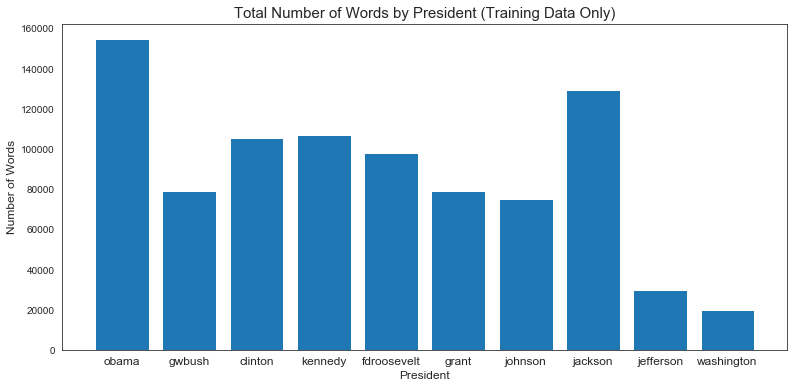

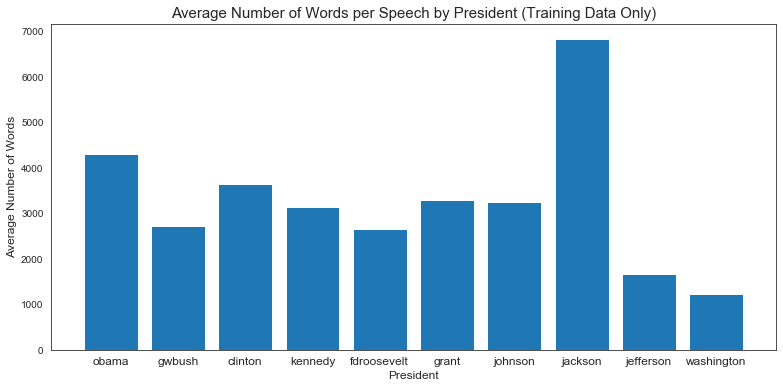

In [55]:
# Creating a list of all the total number of words per president
president_word_counts = []
for president in presidents:
    president_word_count = 0
    for doc in df_train[df_train['president_'] == president]['doc_']:
        for token in doc:
            if not token.is_punct:  # not counting punctuation as a word
                president_word_count += 1
    president_word_counts.append(president_word_count)  

president_speech_counts = []
for president in presidents:
    president_speech_counts.append(len(df_train[df_train['president_'] == president]))

average_words_per_speech = np.divide(president_word_counts, president_speech_counts)    

# plotting our results
sns.set_palette('tab10')
plt.figure(figsize = (13,6))
plt.bar(height = president_word_counts, x = presidents)
plt.title('Total Number of Words by President (Training Data Only)', fontsize = 15)
plt.ylabel('Number of Words', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

plt.figure(figsize = (13,6))
plt.bar(height = average_words_per_speech, x = presidents)
plt.title('Average Number of Words per Speech by President (Training Data Only)', fontsize = 15)
plt.ylabel('Average Number of Words', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

Now we do encounter a lot of imbalance when accounting for total number of words per president. There is certainly not a lot of information about either Jefferson or Washington as opposed to more recent presidents. But we are not clustering according to word count. Instead we are clustering by number of speeches, so the imbalance should not affect as much.

Some noteworthy observations from these graphs is that Obama has quite a bit more words than Washington as he has higher number of speeches. And Andrew Jackson has a very high word count per speech. This information may prove useful when using word count per per speech a feature of the model. 

# Clustering the Data

## Bag of Words

The first model we will be using for this is the Bag of Words model, where we count the number of instances of certain words per document. Using the 50 most common words spoken by each president as our features for the document-term matrix. We will be using lemmas of words throughout this document. In morphology and lexicography, a lemma is the canonical form, dictionary form, or citation form of a set of words. In English, for example, run, runs, ran and running are forms of the same lexeme, with run as the lemma by which they are indexed.

We will join each president's spaCy docs together, giving us one doc per president.

In [56]:
# joining the strings of each president's speeches together
president_files_joined = []
for n in range(len(presidents)): 
    president_files_joined.append(' '.join(
        df_train[df_train['president_'] == presidents[n]]['text_']))

# converting the joined strings to spaCy docs
# (it seems there is no straightforward way of joining spaCy docs together)
president_docs_joined = [] 
for index, president_file_joined in enumerate(president_files_joined):
    president_docs_joined.append(nlp(president_file_joined))
    print('converted the joined {} file to a spaCy doc'.format(presidents[index]))

converted the joined obama file to a spaCy doc
converted the joined gwbush file to a spaCy doc
converted the joined clinton file to a spaCy doc
converted the joined kennedy file to a spaCy doc
converted the joined fdroosevelt file to a spaCy doc
converted the joined grant file to a spaCy doc
converted the joined johnson file to a spaCy doc
converted the joined jackson file to a spaCy doc
converted the joined jefferson file to a spaCy doc
converted the joined washington file to a spaCy doc


## 50 Most Common Words per President

In [57]:
def bag_of_words(doc, number_of_words_per_president):
    
    '''
    Function to create a list of the most common words spoken by each president.

    We input a spaCy doc of the joined speeches for a president and 
    the number of most common words we seek to determine.

    '''
    
    # Loop through each doc and filter out punctuation and stop words.
    # we will collect the most common words from each doc.
    
    allwords = []
    for token in doc:
        if not token.is_punct and not token.is_stop:
                allwords.append(token.lemma_)

    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(
        number_of_words_per_president)]
            
# creating a list of all presidents most common words
# the length of this list will be number_of_words_per_president * 10
# because we have 10 presidents
list_of_all_presidents_most_common_words = []
for n in range(len(presidents)):
    list_of_all_presidents_most_common_words.extend(
        bag_of_words(president_docs_joined[n], 50))

# Creating our list of features
# This is the set of the most common words of all the presidents
# list_of_all_presidents_most_common_words has duplicate words 
# since some words are common in multiple presidents
common_words = list(set(list_of_all_presidents_most_common_words))
print('We have a total of {} most common words \
for all the presidents.'.format(len(common_words)))

We have a total of 191 most common words for all the presidents.


We find with our function that there are 191 words in a set of supposedly 500 words. What that means is in the total of 500 words, some ended up being duplicates to the same words used by other presidents. After all, having duplicates would only cause things to be less accurate.

In [58]:
def bow_features(df_init, common_words):
    
    '''
    This function takes in our original data frame of spaCy docs, 
    text files and cooresponding presidents along with a list 
    of the most common words to concider.

    It returns our desired Bag of Words document-term matrix.

    '''
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['doc_'] = df_init.loc[:, 'doc_']
    df['text_'] = df_init.loc[:, 'text_']
    df['president_'] = df_init.loc[:, 'president_']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, doc in enumerate(df['doc_']):

        # Convert the paragraphs to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = []
        for token in doc:
            lemma = token.lemma_
            if lemma in common_words:
                words.append(lemma)
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 10 == 0:
            print("Processing row {}".format(i))
            
    return df

In [59]:
# Creating the document-term matrix 
# This process can take some time.
# We will record how many seconds it takes. 
start = time.time()
df_bow_50 = bow_features(df_train, common_words)
end = time.time()
print(end - start)

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210
Processing row 220
Processing row 230
Processing row 240
Processing row 250
Processing row 260
31.51344585418701


This took less time than expected, only about 30 seconds. But now we have our term-document matrix

In [62]:
df_bow_50.head(10)

,state,purpose,terror,Secretary,peace,good,nuclear,believe,pay,meet,...,get,worker,great,subject,parent,future,respect,doc_,text_,president_
0,0,0,0,0,0,2,0,2,2,0,...,1,0,1,1,0,0,0,"(To, the, Senate, of, the, United, States, :, ...",To the Senate of the United States: I transmit...,grant
1,14,8,0,15,11,9,0,3,7,2,...,0,0,17,9,0,0,7,"(Fellow, -, Citizens, of, the, Senate, and, Ho...",Fellow-Citizens of the Senate and House of Rep...,johnson
2,4,2,0,6,1,13,0,4,4,4,...,5,2,18,1,0,3,1,"(Mr., President, ,, and, gentlemen, :, I, unde...","Mr. President, and gentlemen: I understand tha...",kennedy
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,"(Whereas, it, appears, that, a, state, of, war...",Whereas it appears that a state of war exists ...,washington
4,4,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,"(To, the, Senate, of, the, United, States, :, ...",To the Senate of the United States: In reply t...,johnson
5,3,2,11,2,17,6,2,0,1,1,...,0,0,18,0,0,0,4,"(Thank, you, very, much, ,, General, Lennox, ....","Thank you very much, General Lennox. Mr. Secre...",gwbush
6,3,1,0,2,1,2,0,0,0,1,...,0,0,5,2,0,0,1,"(Fellow, citizens, of, the, Senate, and, House...",Fellow citizens of the Senate and House of Rep...,washington
7,4,0,1,1,8,17,4,16,9,4,...,11,5,6,0,21,10,2,"(Mr., Chairman, ,, Mr., Vice, President, ,, my...","Mr. Chairman, Mr. Vice President, my fellow De...",clinton
8,1,3,0,0,2,1,0,1,0,3,...,0,0,5,2,0,1,1,"(Mr., Chairman, ,, ladies, and, gentlemen, :, ...","Mr. Chairman, ladies and gentlemen: I apprecia...",kennedy
9,2,8,0,0,1,10,0,4,5,3,...,4,1,8,0,0,4,0,"(On, a, Sunday, night, a, week, after, my, Ina...",On a Sunday night a week after my Inauguration...,fdroosevelt


# Using K-Means clustering to analyze our document-term matrix

In [63]:
def k_means_analysis(X, y_true, n_clusters, params, description):
    
    """ 
    This function takes as inputs the document-term matrix X, the labels y_true, 
    the number of clusters, other k-means parameters and a description of the input 
    martix properties.

    While it does not return anything explicitly, it plots properties of the 
    confusion matrix and makes scatterplots of the true labels and k-means clustering
    labels along the two primary LSA components. It also gives statistics on the ARI, 
    completeness, homogeneity, and v_measure_scores after running the clustering 
    algorithm ten times. Note that the bar plots and scatter plots are of the tenth
    trial used to determine the scoring statistics.

    """
    
    # we will cluster our data ten times and calculate statistics of 
    # our metrics for cluster evaluation.
    number_of_trials = 10
    
    ari_scores = []
    completeness_scores = []
    homogeneity_scores = []
    v_measure_scores = []
    
    for trial in range(number_of_trials):

        # we will use scikit-learns MiniBatchKMeans function
        minibatchkmeans = MiniBatchKMeans(
            **params, n_clusters=n_clusters, random_state=trial)
            # this uses the same 10 different random_states each time the code is run)

        # fitting k-means and predicting on our data
        y_pred = minibatchkmeans.fit_predict(X)
        ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
        completeness_scores.append(metrics.completeness_score(y_true, y_pred))
        homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
        v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

    # we will print our the score after our plots
        
    # calculating the contigency table for our clustering
    # this will be clustering of the last of the trials.
    # we have to choose one of the ten clusterings to evaluate.
    
    contigency_table = pd.crosstab(y_pred, y_true)[presidents]

    # Normalizing the contigency table. 
    # We seek to know the percentage of each presidents speeches in a given cluster.
    contigency_table_normalized = pd.DataFrame(
        normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
    contigency_table_normalized.columns = [presidents]
    
    
    # plotting a very similar graph from the transpose of the contingency matrix
    # normalizing the crosstab scores so that we can see a given cluster's 
    # presidental constituents
    crosstab_normalized_T = pd.DataFrame(
        normalize(np.array(contigency_table).T,  axis = 0, norm = 'l1'))
    crosstab_normalized_T.columns = range(n_clusters)

    
    
    
    # ploting this contigency table as a staked bar plot
    sns.set_palette('tab10')
    ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
    ax3.set(xticklabels = presidents)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title('Fraction of President\'s Speeches in K-Means Clusters\n Using '
              + str(description), fontsize = 12)
    plt.xlabel('President', fontsize = 12)
    plt.ylabel('Fraction', fontsize = 12) 
    plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1),
               prop={'size': 12})
    plt.ylim(0,1)
    plt.show()

    # plotting a presidents cluster breakdown
    sns.set_palette('bright')
    ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
    ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(len(presidents)))
    plt.xticks(fontsize = 12, rotation='horizontal')
    plt.yticks(fontsize = 12)
    plt.xlabel('Cluster', fontsize = 12)
    plt.ylabel('Fraction', fontsize = 12) 
    plt.legend(presidents, title = 'President', title_fontsize = 12,
               bbox_to_anchor=(1, 1), prop={'size': 12})
    plt.ylim(0,1)
    plt.title('The Relative Constituents of Each K-Means Cluster\n Using '
              + str(description), fontsize = 12)
    plt.show()

    
    # making a two scatter plots of the clusters labeled by predicted cluster 
    # and true class. We will plot their projection onto the two primary 
    # LSA components.
    
    # creating a data frame with the two LSA components
    lsa2 = TruncatedSVD(n_components=2)
    X_lsa2 = lsa2.fit_transform(X)
    df_lsa2 = pd.DataFrame(X_lsa2)
    df_lsa2['y_true'] = y_true
    df_lsa2['y_pred'] = y_pred
    df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

    # plotting the speech along the 2 principal compontents of LSA 
    # (Latent Semantic Analysis) 
    plt.figure(figsize=(13,6))
    sns.set_palette('tab10')    
    plt.subplot(1, 2, 1)
    plt.title('K-Means Clusters Projected onto LSA Components\nUsing '
              + str(description), fontsize = 12)
    ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                          palette=['C0', 'C1', 'C2','C3','C4','C5',
                                   'C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
    legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
    legend.texts[0].set_text("Cluster")
    plt.xlabel('LSA Component 0')
    plt.ylabel('LSA Component 1')
    
    plt.subplot(1, 2, 2)
    plt.title('Speeches by President Projected onto LSA Components\nUsing '
              + str(description), fontsize = 12)
    ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true', hue_order = presidents,
                          palette = 'bright', data = df_lsa2)
    legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
    legend.texts[0].set_text("President")
    plt.xlabel('LSA Component 0')
    plt.ylabel('LSA Component 1')
    plt.show()

    print('Using {}'.format(description))    
    print('ARI score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(ari_scores), 3),
        round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
    print('completeness score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(completeness_scores), 3),
        round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
    print('homogeneity score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(homogeneity_scores), 3),
        round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
    print('v-measure score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(v_measure_scores), 3), 
        round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))

In [64]:
def k_means_scores(X, y_true, n_clusters, params, description):
    
    """ 
    This function takes as inputs the document-term matrix X, the labels y_true, 
    the number of cluster, other parameters and a description of the input martix 
    properties.

    While it does not return anything explicitly, it gives statistics on the ARi, 
    completeness, homogeneity, and v_measure_scores after running the clustering 
    algorithm ten times. 

    """
    
    # we will cluster our data ten times and calculate statistics of our metrics 
    # for cluster evaluation.
    number_of_trials = 10
    
    ari_scores = []
    completeness_scores = []
    homogeneity_scores = []
    v_measure_scores = []
    
    for trial in range(number_of_trials):

        # we will use scikit-learns MiniBatchKMeans function
        minibatchkmeans = MiniBatchKMeans(**params, n_clusters=n_clusters,
                                          random_state=trial)
        # this uses the same 10 different random_states each time the code is run)

        # fitting k-means and predicting on our data
        y_pred = minibatchkmeans.fit_predict(X)
        ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
        completeness_scores.append(metrics.completeness_score(y_true, y_pred))
        homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
        v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

    print('Using {}'.format(description))    
    print('ARI score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(ari_scores), 3),
        round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
    print('completeness score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(completeness_scores), 3),
        round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
    print('homogeneity score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(homogeneity_scores), 3),
        round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
    print('v-measure score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(v_measure_scores), 3),
        round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))

### Using K-means to cluster df_bow_50

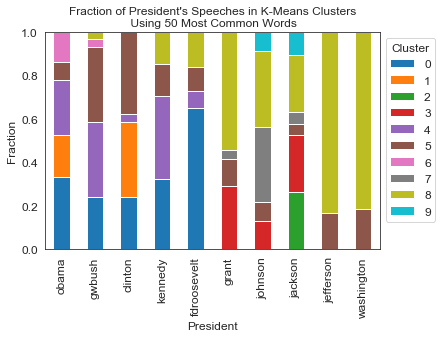

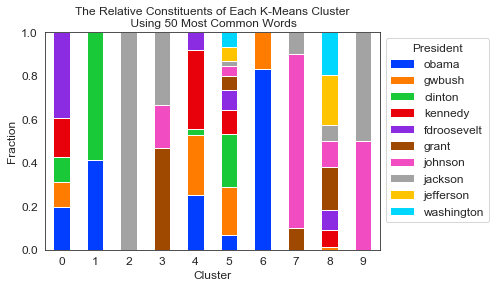

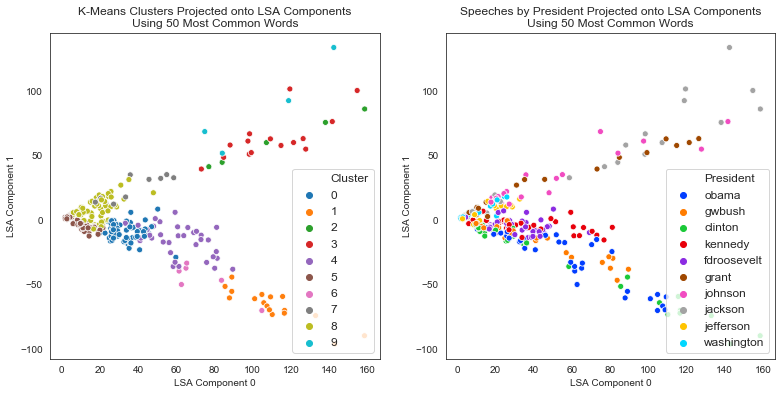

Using 50 Most Common Words
ARI score: 0.068 +/- 0.018
completeness score: 0.364 +/- 0.017
homogeneity score: 0.260 +/- 0.020
v-measure score: 0.303 +/- 0.018


In [65]:
X_bow_50 = np.array(df_bow_50.drop(['doc_', 'text_', 'president_'], 1))
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words'
k_means_analysis(X_bow_50, y_true, n_clusters, params, description)

Our first two bar plots are contingency tables. What we are looking for in the first table is the completeness score. This plot tells us how well each president's speeches are clustered in the same cluster. If the entire bar was a solid color, that means each president would be clustered into their appropriate cluster.

The second bar plot is our homogeneity plot. If one bar is a solid color, the homogeneity score would be a 1.0 because the entire cluster would containe only one president's speeches. If we were to have perfect clustering, each president would have their own bar in both the first and second plots.

The first scatter plot shows our model's clusters projected on the primary LSA components. This plot is color coded to our first contingency table. 
The second scatter plot shows the true labels per dot projected onto the two primary LSA components. This scatter plot is color coded with our second continency table.

In our first two tables, we see a lot of that dark blue color in the first half of the table and then the second half has a lot of the green color. This may be due to the difference in years, as the first half is the presidents after 1900, the latter half contain the presidents who held office before 1900. 

In the second scatterplot, its sparser on top than it is on bottom. The bottom half contains most of the recent presidents whereas the top half contains most of the older presidents. We are, so far it seems, at least able to somewhat classify recent presidents versus older ones. 

Considering scoring, we run the clustering algorithm 10 times on the input matrix and then calculate the mean and twice the standard deviations of the mean to use as our values for the mean score and its uncertainty.

From the Adjusted Rand Index (ARI) we see that he clustering does a bad job of clustering speeches by president. We will have a high ARI score if pairs of points that are from the same president are clustered in the same cluster and if pairs of points that are not from the same president are located in different clusters.

The completeness gives us a score of how well a given president's speeches are grouped into the same cluster. The homogeniety score gives us a measure of how homogeneous our clusters are. And finally the v-measure score is the harmonic mean of our homogeneity and completeness scores.

### Scaling df_bow_50 features

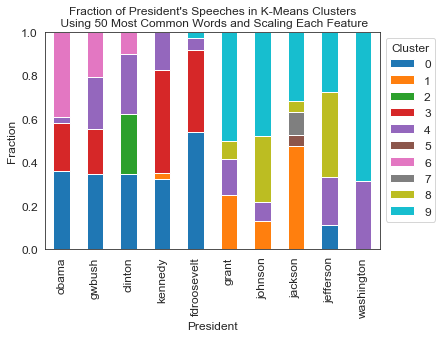

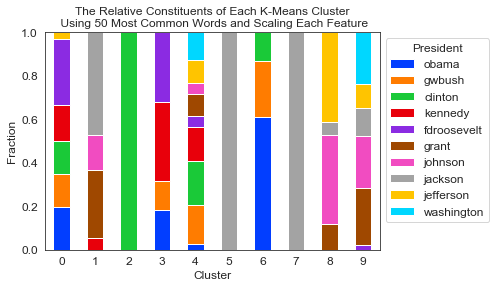

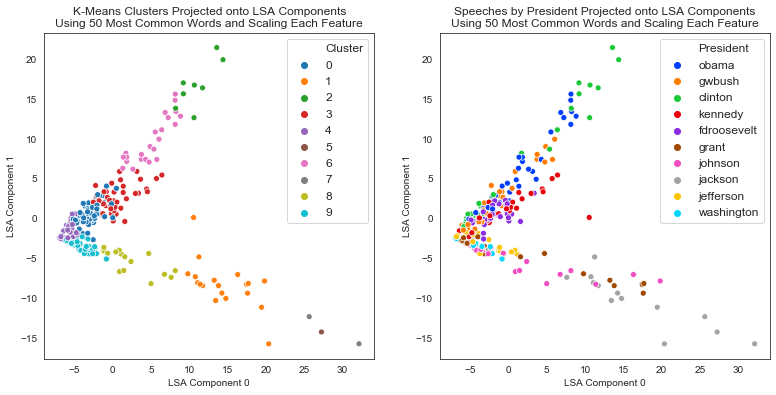

Using 50 Most Common Words and Scaling Each Feature
ARI score: 0.069 +/- 0.023
completeness score: 0.393 +/- 0.018
homogeneity score: 0.275 +/- 0.027
v-measure score: 0.322 +/- 0.024


In [66]:
X_bow_50 = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 0)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words and Scaling Each Feature'
k_means_analysis(X_bow_50, y_true, n_clusters, params, description)

Scaling the features helped each and every one of our scores but only by a bit. The only noticeable visual change is the upper leg of our v-shaped graph now has the more recent presidents rather than the lower one.

### Scaling df_bow_50 samples

This hopefully will help treat documents fairly by length. The coefficients can help combat the word count issue, making longer speeches scale down a bit to make treating the documents more equal.

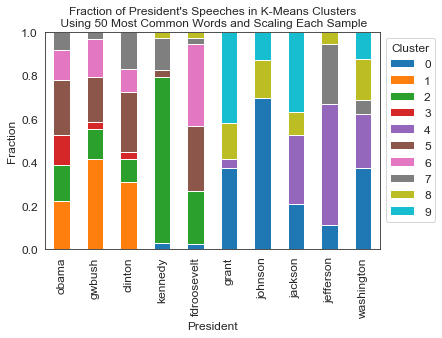

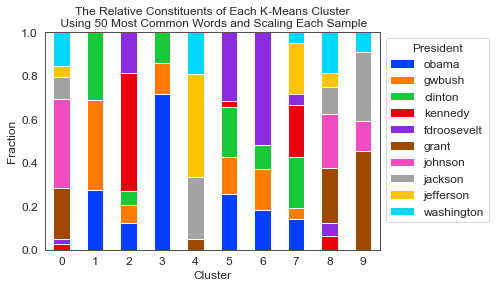

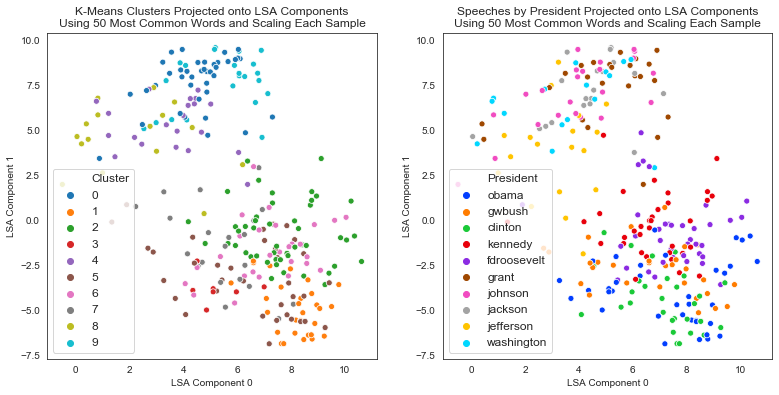

Using 50 Most Common Words and Scaling Each Sample
ARI score: 0.244 +/- 0.013
completeness score: 0.452 +/- 0.017
homogeneity score: 0.435 +/- 0.014
v-measure score: 0.443 +/- 0.015


In [67]:
X_bow_50 = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words and Scaling Each Sample'
k_means_analysis(X_bow_50, y_true, n_clusters, params, description)

This scaling worked significantly better. The first bar graph contains a certain set of colors in the left half versus the right half and you can see quite a clear divide on the clustering in the scatterplots. Instead of a v-shape, we have a blob with the clear divide through the middle. Again we are ablet o see time period clustering very well. Which begs us to check how well it looks when we instead cluster by 2 instead of 10.

### Scaling df_bow_50 by sample and using 2 clusters

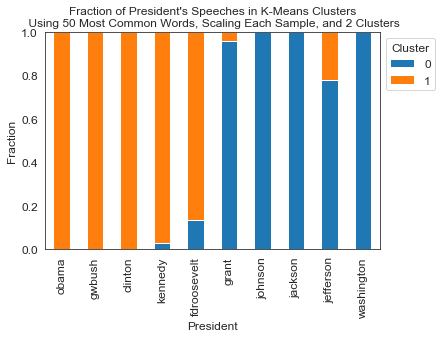

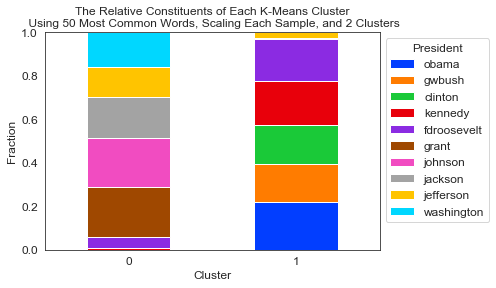

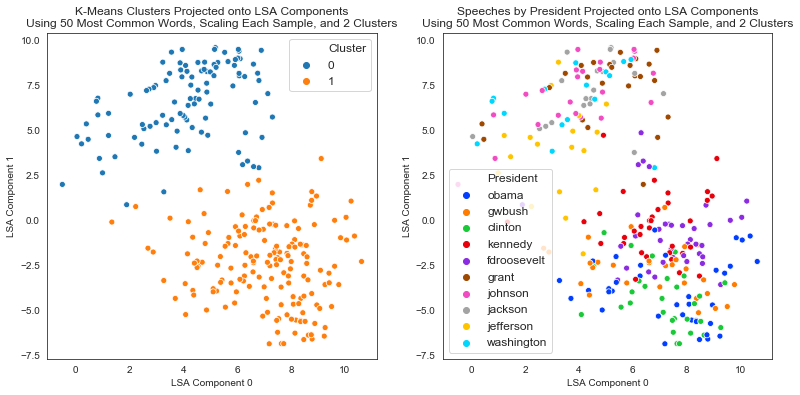

Using 50 Most Common Words, Scaling Each Sample, and 2 Clusters
ARI score: 0.161 +/- 0.002
completeness score: 0.820 +/- 0.008
homogeneity score: 0.241 +/- 0.003
v-measure score: 0.372 +/- 0.004


In [68]:
X_bow_50 = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
y_true = df_bow_50['president_']
n_clusters = 2
params = {}
description = '50 Most Common Words, Scaling Each Sample, and 2 Clusters'
k_means_analysis(X_bow_50, y_true, n_clusters, params, description)

This proves just how well our clustering methos is able to group by time period. The completeness score is quite high, indicating exactly that and the errors are much lower than in that of our previous calculations. 

So now we will try to use LSA (the PCA of document-term matrix world) and see if that helps our renders.

### LSA df_bow_50 with 5 components scaling by sample

In [82]:
X = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=5, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words, Scaling Each Sample, and LSA-5'
k_means_scores(X_lsa, y_true, n_clusters, params, description)

Using 50 Most Common Words, Scaling Each Sample, and LSA-5
ARI score: 0.207 +/- 0.008
completeness score: 0.421 +/- 0.009
homogeneity score: 0.418 +/- 0.008
v-measure score: 0.420 +/- 0.008


### LSA df_bow_50 with 10, 20, and 100 scaling by sample

We have found the best clustering algorithm for our goal I believe, and this can be shown by increasing the components used. So here we will try 10, 20, and 100. With 190 features, cutting out even 90 of them can be enough dimensionality reduction to improve our scores significantly.

In [83]:
X = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=10, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words, Scaling Each Sample, and LSA-10'
k_means_scores(X_lsa, y_true, n_clusters, params, description)

print('\n')
X = scale(np.array(df_bow_50.drop(['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=20, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words, Scaling Each Sample, and LSA-20'
k_means_scores(X_lsa, y_true, n_clusters, params, description)

print('\n')
X = scale(np.array(df_bow_50.drop(['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=100, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words, Scaling Each Sample, and LSA-100'
k_means_scores(X_lsa, y_true, n_clusters, params, description)

Using 50 Most Common Words, Scaling Each Sample, and LSA-10
ARI score: 0.238 +/- 0.016
completeness score: 0.449 +/- 0.012
homogeneity score: 0.443 +/- 0.010
v-measure score: 0.446 +/- 0.011


Using 50 Most Common Words, Scaling Each Sample, and LSA-20
ARI score: 0.243 +/- 0.022
completeness score: 0.455 +/- 0.019
homogeneity score: 0.451 +/- 0.020
v-measure score: 0.453 +/- 0.019


Using 50 Most Common Words, Scaling Each Sample, and LSA-100
ARI score: 0.240 +/- 0.021
completeness score: 0.458 +/- 0.021
homogeneity score: 0.437 +/- 0.018
v-measure score: 0.447 +/- 0.018


### Bag of Words Conclusion

I believe the winning clustering algorithm scales by sample and reduces the matrix's dimensionality to 10 LSA components and implements k-means. This is its score

Using 50 Most Common Words, Scaling Each Sample, and LSA-10
ARI score: 0.238 +/- 0.016
completeness score: 0.449 +/- 0.012
homogeneity score: 0.443 +/- 0.010
v-measure score: 0.446 +/- 0.011

There's a myriad of combinations to try for this matrix. And many other algorithms as well. Affinity propagation, MiniBatchKMeans, etc. can all be viable. But for sake of consistency, we will attempt to continue to use Bag of Words but instead have more words to work with.

In [84]:
# creating a list of all presidents most common words
# the length of this list will be number_of_words_per_president * 10
# because we have 10 presidents
list_of_all_presidents_most_common_words = []
for n in range(len(presidents)):
    list_of_all_presidents_most_common_words.extend(
        bag_of_words(president_docs_joined[n], 500))

# Creating our list of features
# This is the set of the most common words of all the presidents
# list_of_all_presidents_most_common_words has duplicate words 
# since some words are common in multiple presidents
common_words = list(set(list_of_all_presidents_most_common_words))
print('We have a total of {} most common words for all the presidents.'.format(
    len(common_words)))

We have a total of 1534 most common words for all the presidents.


In [85]:
# Creating the document-term matrix 
# This process can take some time.
# We will record how many seconds it takes. 
start = time.time()
df_bow_500 = bow_features(df_train, common_words)
end = time.time()
print(end - start)

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210
Processing row 220
Processing row 230
Processing row 240
Processing row 250
Processing row 260
103.11142921447754


In [86]:
df_bow_500.head()

,objection,conviction,prior,nuclear,judge,basis,expenditure,withdraw,Houses,Domingo,...,share,assistance,involve,qualification,perceive,affordable,indispensable,doc_,text_,president_
0,1,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,"(To, the, Senate, of, the, United, States, :, ...",To the Senate of the United States: I transmit...,grant
1,0,2,3,0,1,1,24,0,1,4,...,0,0,7,0,0,0,1,"(Fellow, -, Citizens, of, the, Senate, and, Ho...",Fellow-Citizens of the Senate and House of Rep...,johnson
2,0,0,0,0,0,5,8,1,0,0,...,5,0,3,0,0,0,0,"(Mr., President, ,, and, gentlemen, :, I, unde...","Mr. President, and gentlemen: I understand tha...",kennedy
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(Whereas, it, appears, that, a, state, of, war...",Whereas it appears that a state of war exists ...,washington
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(To, the, Senate, of, the, United, States, :, ...",To the Senate of the United States: In reply t...,johnson


Using k-means are our base algorithm, we will find the best document-term matrix. Then we will see how it performs with other clustering algorithms. But let's see what combination of scaling and LSA is best for our data.

### Top 500 Bag of Words using k-means with no scaling¶

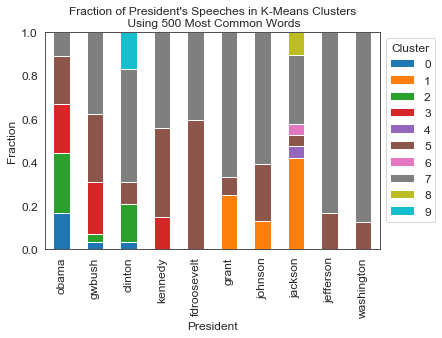

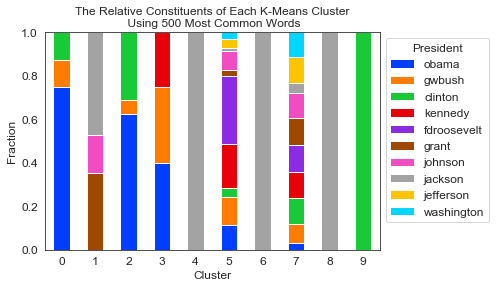

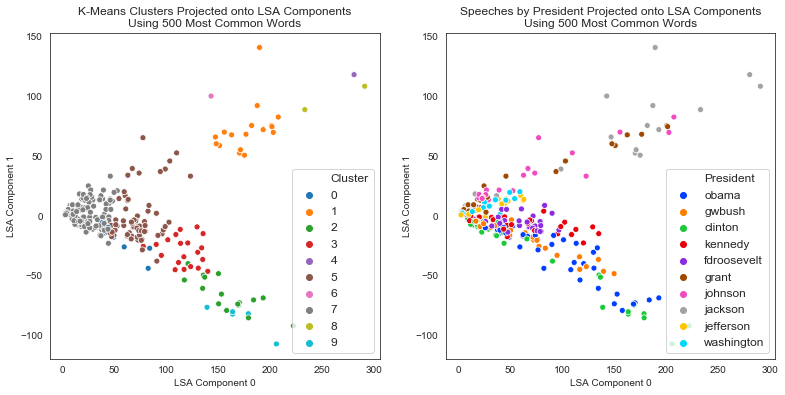

Using 500 Most Common Words
ARI score: 0.056 +/- 0.012
completeness score: 0.325 +/- 0.017
homogeneity score: 0.225 +/- 0.014
v-measure score: 0.266 +/- 0.015


In [87]:
X_bow_500 = np.array(df_bow_500.drop(['doc_', 'text_', 'president_'], 1))
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words'
k_means_analysis(X_bow_500, y_true, n_clusters, params, description)

This performed remarkably worse than Top 50 Bag of Words. Now instead we can scale each sample and see how those perform.

### df_bow_500 scaling by feature

In [88]:
X_bow_500 = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 0)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling by Feature'
k_means_scores(X_bow_500, y_true, n_clusters, params, description)

Using 500 Most Common Words, Scaling by Feature
ARI score: 0.038 +/- 0.004
completeness score: 0.421 +/- 0.017
homogeneity score: 0.195 +/- 0.013
v-measure score: 0.266 +/- 0.013


And it's gotten worse. Let's scale by sample instead of by feature.

### df_bow_500 scaling by sample

In [89]:
X_bow_500 = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling by Sample'
k_means_scores(X_bow_500, y_true, n_clusters, params, description)

Using 500 Most Common Words, Scaling by Sample
ARI score: 0.229 +/- 0.011
completeness score: 0.456 +/- 0.018
homogeneity score: 0.419 +/- 0.016
v-measure score: 0.437 +/- 0.016


Naturally scaling by sample leads to better scores, as it did with df_bow_50. Now these scores are close to the same as df_bow_50's ARI score, so let's apply LSA and see how things start to look

### LSA df_bow_500  scaling by sample with 5, 10, 20, and 30 components

In [91]:
X = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=5, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling Each Sample, and LSA-5'
k_means_scores(X_lsa, y_true, n_clusters, params, description)
print('\n')
X = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=10, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling Each Sample, and LSA-10'
k_means_scores(X_lsa, y_true, n_clusters, params, description)
print('\n')
X = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=20, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling Each Sample, and LSA-20'
k_means_scores(X_lsa, y_true, n_clusters, params, description)
print('\n')
X = scale(np.array(df_bow_500.drop(['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=30, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling Each Sample, and LSA-30'
k_means_scores(X_lsa, y_true, n_clusters, params, description)

Using 500 Most Common Words, Scaling Each Sample, and LSA-5
ARI score: 0.182 +/- 0.007
completeness score: 0.384 +/- 0.006
homogeneity score: 0.378 +/- 0.007
v-measure score: 0.381 +/- 0.007


Using 500 Most Common Words, Scaling Each Sample, and LSA-10
ARI score: 0.259 +/- 0.016
completeness score: 0.452 +/- 0.010
homogeneity score: 0.451 +/- 0.010
v-measure score: 0.451 +/- 0.010


Using 500 Most Common Words, Scaling Each Sample, and LSA-20
ARI score: 0.272 +/- 0.022
completeness score: 0.469 +/- 0.015
homogeneity score: 0.462 +/- 0.018
v-measure score: 0.465 +/- 0.016


Using 500 Most Common Words, Scaling Each Sample, and LSA-30
ARI score: 0.256 +/- 0.018
completeness score: 0.458 +/- 0.019
homogeneity score: 0.447 +/- 0.018
v-measure score: 0.453 +/- 0.018


So with 20 components, we reach the highest ARI score we've had. So this is what we will stick to!

In [92]:
def plotting_scores_vs_number_of_LSA_components(
    X, min_components, max_components, delta_components, number_of_trials):
    '''
    This function plots the four clustering scores of a document-term matrix
    versus the number of LSA components used. We input the matrix,
    the minimum and maximum number of LSA components to plot, along with
    a step size delta_components, and the number of trials to use for each
    number of LSA components.
    
    '''
    components = list(range(min_components, max_components, delta_components))
    
    mean_ari_scores = []
    sigma2_ari_scores = []
    mean_completeness_scores = []
    sigma2_completeness_scores = []
    mean_homogeneity_scores = []
    sigma2_homogeneity_scores = []
    mean_v_measure_scores = []
    sigma2_v_measure_scores = []

    for n_components in components:

        lsa = TruncatedSVD(n_components=n_components)
        X_lsa = lsa.fit_transform(X) 

        ari_scores = []
        completeness_scores = []
        homogeneity_scores = []
        v_measure_scores = []

        # Looping through k-means ten times and recording statistics.
        for trial in range(number_of_trials):

            # we will use scikit-learns MiniBatchKMeans function
            minibatchkmeans = MiniBatchKMeans(**params, n_clusters=n_clusters)

            # fitting k-means and predicting on our data
            y_pred = minibatchkmeans.fit_predict(X_lsa)

            ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
            completeness_scores.append(metrics.completeness_score(y_true, y_pred))
            homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
            v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

        mean_ari_scores.append(np.mean(ari_scores))
        sigma2_ari_scores.append(
            2*np.std(ari_scores)/np.sqrt(number_of_trials))
        mean_completeness_scores.append(np.mean(completeness_scores))
        sigma2_completeness_scores.append(
            2*np.std(completeness_scores)/np.sqrt(number_of_trials))
        mean_homogeneity_scores.append(np.mean(homogeneity_scores))
        sigma2_homogeneity_scores.append(
            2*np.std(homogeneity_scores)/np.sqrt(number_of_trials))
        mean_v_measure_scores.append(np.mean(v_measure_scores))
        sigma2_v_measure_scores.append(
            2*np.std(v_measure_scores)/np.sqrt(number_of_trials))
    # Plotting the two figures.    
    plt.figure(figsize=(15,15))

    plt.subplot(2, 2, 1)
    plt.errorbar(components, mean_ari_scores, yerr = sigma2_ari_scores, capsize=6)
    plt.title('ARI Scores vs Number of LSA Components')
    plt.xlabel('Number of LSA Components')
    plt.ylabel('ARI Score')

    plt.subplot(2, 2, 2)    
    plt.errorbar(components, mean_completeness_scores, yerr = sigma2_completeness_scores, capsize=6)
    plt.title('Completeness Scores vs Number of LSA Components')
    plt.xlabel('Number of LSA Components')
    plt.ylabel('Completeness Score')


    plt.subplot(2, 2, 3)    
    plt.errorbar(components, mean_homogeneity_scores, yerr = sigma2_homogeneity_scores, capsize=6)
    plt.title('Homogeneity Scores vs Number of LSA Components')
    plt.xlabel('Number of LSA Components')
    plt.ylabel('Homogeneity Score')

    plt.subplot(2, 2, 4)    
    plt.errorbar(components, mean_v_measure_scores, yerr = sigma2_v_measure_scores, capsize=6)
    plt.title('V-Measure Scores vs Number of LSA Components')
    plt.xlabel('Number of LSA Components')
    plt.ylabel('V-Measure Score')
    plt.show()

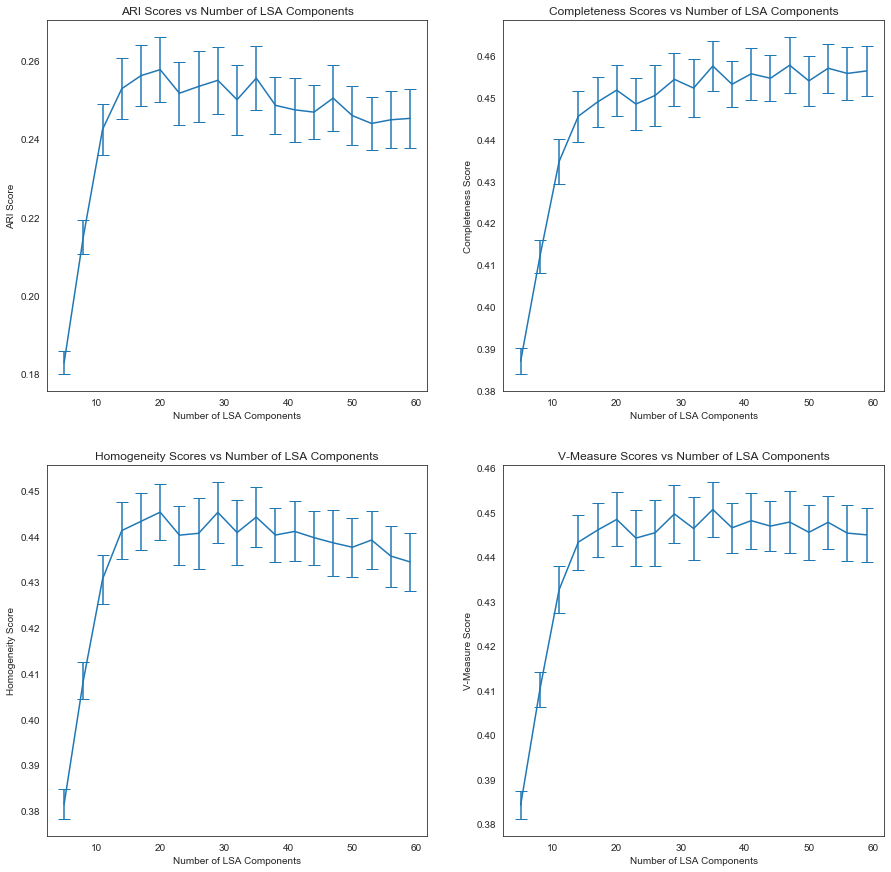

In [93]:
X = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
min_components = 5
max_components = 60
delta_components = 3
number_of_trials = 100
plotting_scores_vs_number_of_LSA_components(
    X, min_components, max_components, delta_components, number_of_trials)

Now with 100 trials for each number of LSA components, we see that if our components are anwyhere above 12 or so, our scores have mostly the same range when considering error possiblity as well. Since we initially started with 20 components, we will continue using the 20 components model as our best model.

### tf-idf document term matrix

In [94]:
# setting the parameters of our tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.6, # drop words that more than 60% of the presidents say
                             min_df=2, # only use words that at least two presidents said
                             stop_words='english', 
                             lowercase=True, # convert everything to lower case 
                             use_idf=True,# we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', 
                             # we will normalize each row of our document term matrix 
                             # to have unit length. Thus, speeches that are longer 
                             # will not be farther from the origin than shorter speeches
                             smooth_idf=True 
                             #Adds 1 to all document frequencies, as if an extra 
                             # document existed that used every word once.  
                             # Prevents divide-by-zero errors
                            )

# fitting the vectorizer to distinguish between the 10 joined speeches for each president:
# we are choosing our features (terms) based on what would be best for determining 
# which president said that term. what would be "best" for making this determination 
# is given by our parameter choices of TfidfVectorizer.
vectorizer.fit(president_files_joined)

# with those features we then create the document-term matrix where each row is a single speech
X_tfidf = vectorizer.transform(np.array(df_train['text_']))

In [95]:
# creating a pandas data frame of our document term matrix
df_tfidf = pd.DataFrame(X_tfidf.toarray())
df_tfidf.columns = vectorizer.get_feature_names()
df_tfidf['president_'] = df_train['president_']
df_tfidf['text_'] = df_train['text_']
df_tfidf.head()

,00,002,003,006,01,010,025,029,034,04,...,youthful,yugoslavia,zealand,zealous,zealously,zero,zone,zones,president_,text_
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,grant,To the Senate of the United States: I transmit...
1,0.0,0.0,0.0,0.0,0.0,0.024015,0.024015,0.0,0.0,0.0,...,0.02101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,johnson,Fellow-Citizens of the Senate and House of Rep...
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,kennedy,"Mr. President, and gentlemen: I understand tha..."
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,washington,Whereas it appears that a state of war exists ...
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,johnson,To the Senate of the United States: In reply t...


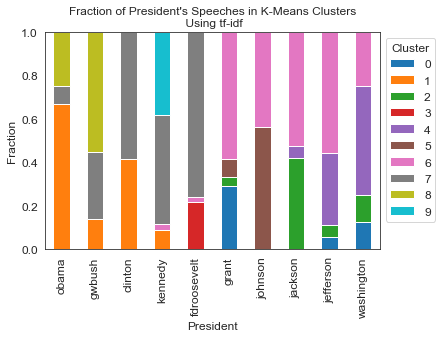

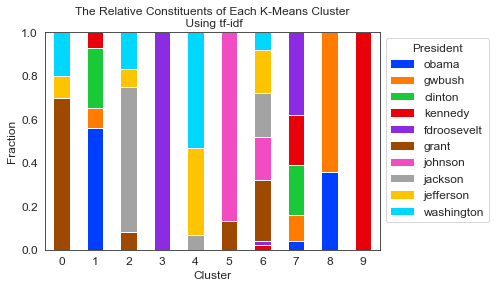

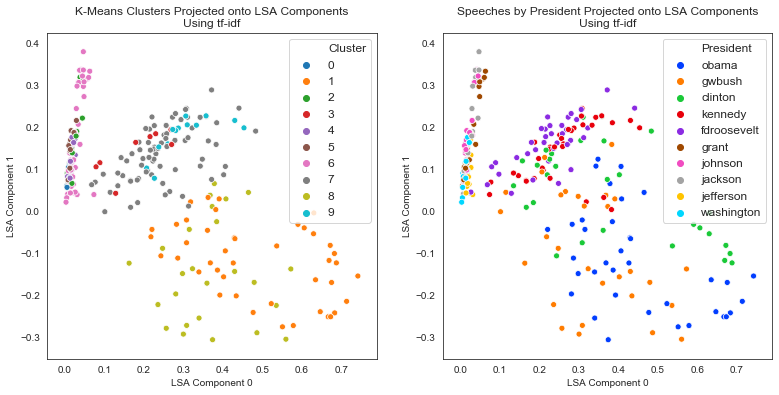

Using tf-idf
ARI score: 0.260 +/- 0.018
completeness score: 0.551 +/- 0.021
homogeneity score: 0.484 +/- 0.013
v-measure score: 0.515 +/- 0.015


In [96]:
y_true = df_tfidf['president_']
n_clusters = 10
params = {}
description = 'tf-idf'
k_means_analysis(X_tfidf, y_true, n_clusters, params, description)

We have the highest scores we've seen in completeneess, homogeneity, and v-measure while ARI is about the same as previous model interations.

Again a color scheme forms with the first 5 presidents versus the last 5 in the bar graphs, showing we have a decent separation again of time period.

The two clusters are somewhat seen in our scatterplot. One very dense line compacted on the left side and a loose shaped blob to the right with quite a lower spread out points.

### Using tf-idf to cluster presidents into two sets

Like we did with k-means, we will try to cluster the two presidents into two sets to see how well that performs and looks

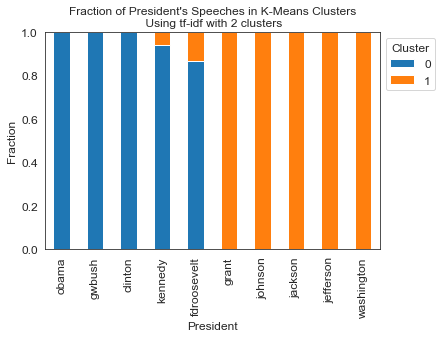

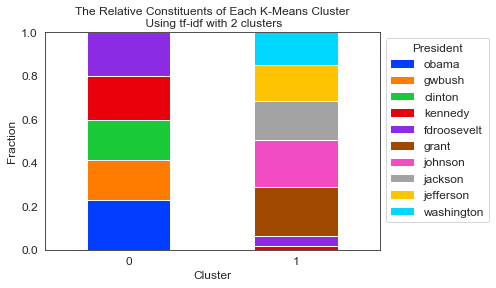

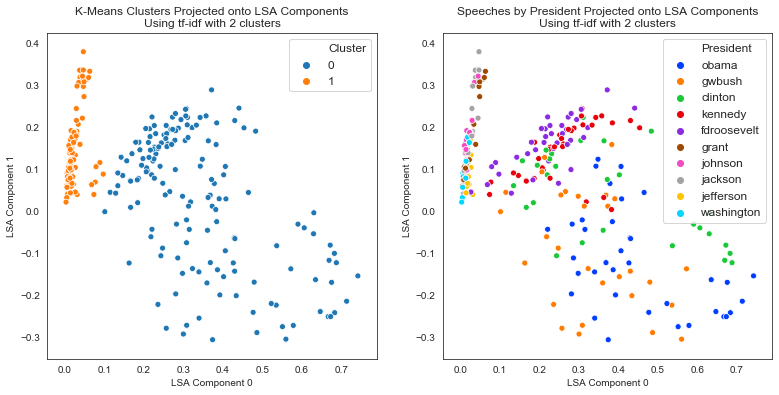

Using tf-idf with 2 clusters
ARI score: 0.171 +/- 0.001
completeness score: 0.872 +/- 0.007
homogeneity score: 0.260 +/- 0.002
v-measure score: 0.400 +/- 0.003


In [97]:
y_true = df_tfidf['president_']
n_clusters = 2
params = {}
description = 'tf-idf with 2 clusters'
k_means_analysis(X_tfidf, y_true, n_clusters, params, description)

It clustered the two sets of presidents almost perfectly. Barely any speeches were categorized incorrectly with the smallest overlap with presidents who are closer in time periods only.

Now using LSA, we will see how well we can get this clustered.

### Plotting scores versus LSA components for tf-idf

In [102]:
lsa = TruncatedSVD(n_components=5, random_state=0)
X_tfidf_lsa = lsa.fit_transform(X_tfidf)
y_true = df_tfidf['president_']
n_clusters = 10
params = {}
description = 'tf-idf and LSA-5'
k_means_scores(X_tfidf_lsa, y_true, n_clusters, params, description)

Using tf-idf and LSA-5
ARI score: 0.182 +/- 0.013
completeness score: 0.479 +/- 0.017
homogeneity score: 0.432 +/- 0.015
v-measure score: 0.454 +/- 0.015


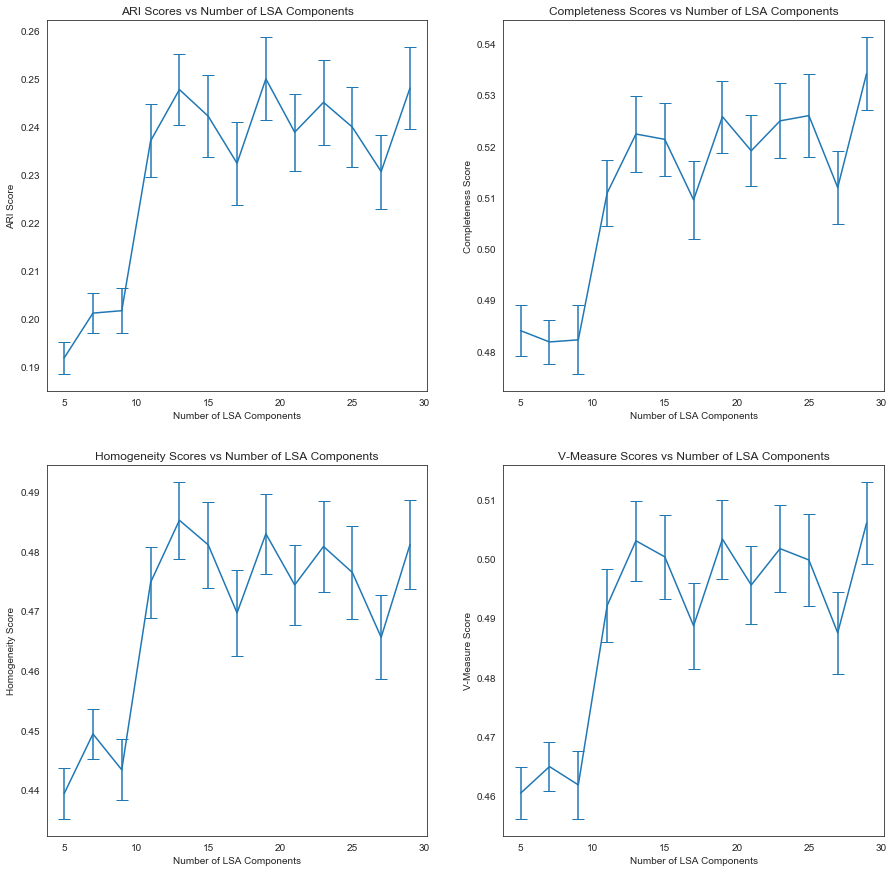

In [101]:
X = X_tfidf
min_components = 5
max_components = 30
delta_components = 2
number_of_trials = 100
plotting_scores_vs_number_of_LSA_components(
    X, min_components, max_components, delta_components, number_of_trials)

Comparing to the previously high ARI score of 26%, we see that none of these scores are comparable. The previous model did not have any LSA done to it, so we will try to add more components once more

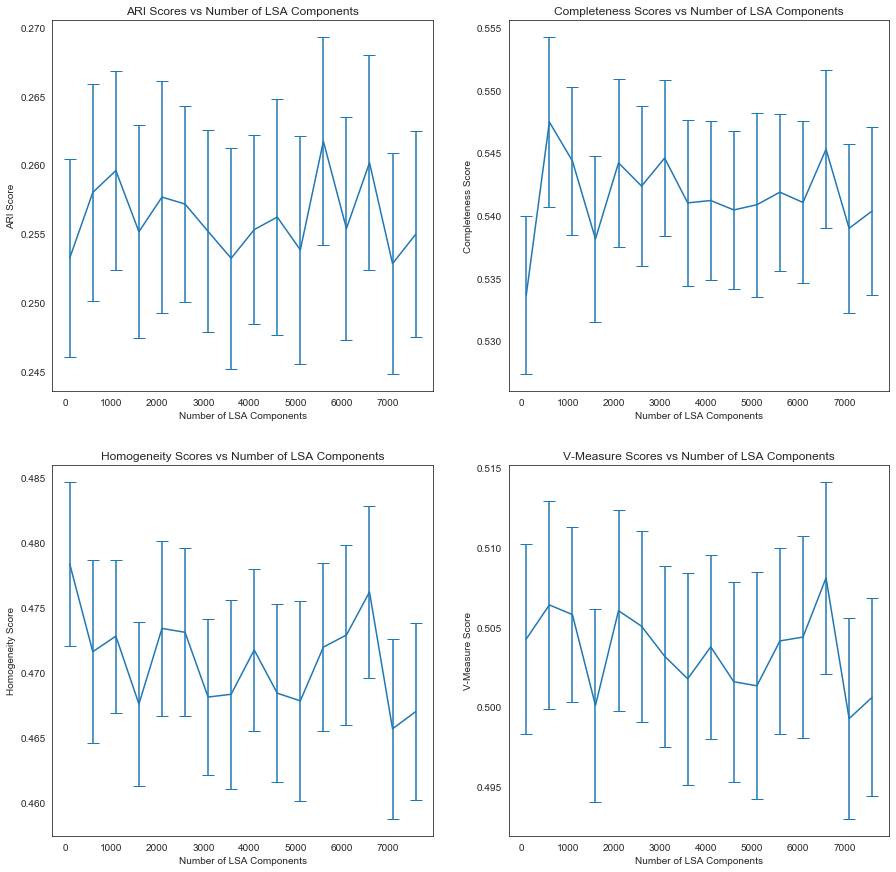

In [103]:
X = X_tfidf
min_components = 100
max_components = 8000
delta_components = 500
number_of_trials = 100
plotting_scores_vs_number_of_LSA_components(X, min_components, max_components, delta_components, number_of_trials)

Our highest score of 26% was reached with the original matrix. Looking at the first chart, our ARI score only slightly touches higher than 26% at the 5600 component mark, so practically speaking, we've already reached the components we will need to use.

Instead, we can iterate through the parameters of our vectorizer to see if different parameters work better for out data.

### Iterating through different max_df and min_df parameters for our tf-idf matrix

df_max is the threshold of whether or not we will include a term in our matrix if it occurs in that many presidents or more.

df_min is the threshold of whether or not we will include a term in our matrix if it occurs in that less than that many presidents.

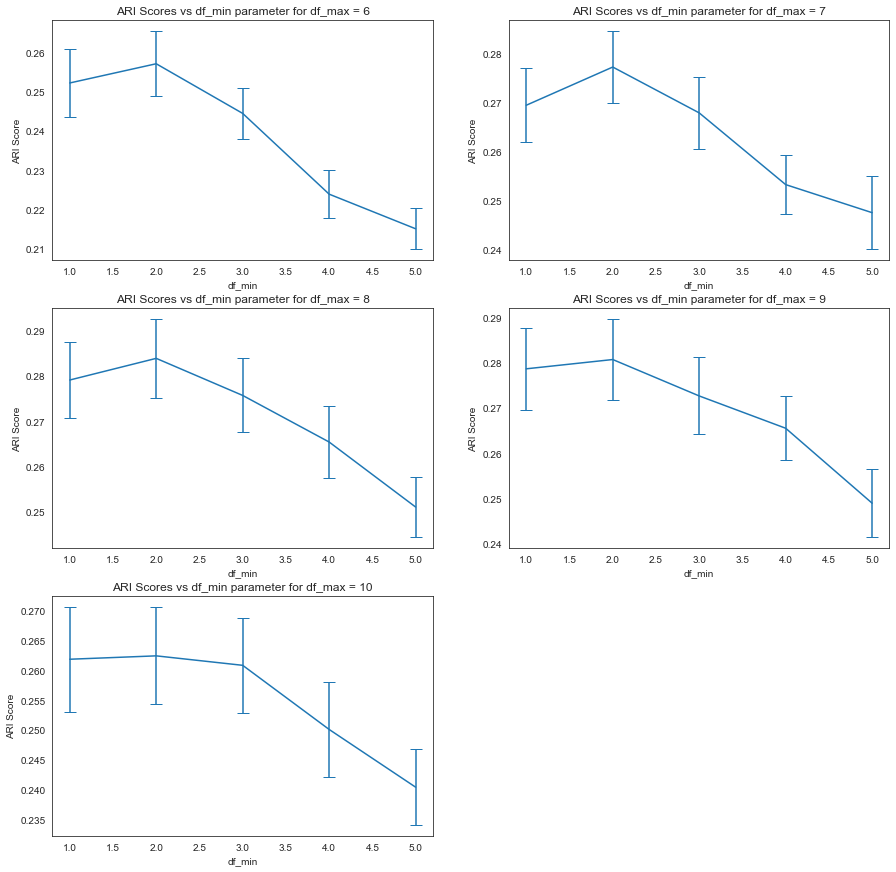

In [104]:
max_dfs = [6,7,8,9,10]
min_dfs = [1,2,3,4,5]

# We will calculate run 100 trails for every combination of df_min and df_max
# and calculate the ARI score for each trial.
number_of_trials = 100

# Initializing our figure.
plt.figure(figsize=(15,15))
for max_df in max_dfs:
    
    # initializing lists to store ARI scores statistics for one df_max value
    # each element is a value for a specific df_min value.
    mean_ari_scores = []
    sigma2_ari_scores = []
    for min_df in min_dfs:
        # initializing lists to store ARI scores
        ari_scores = []
                # setting the parameters of our tf-idf vectorizer
        vectorizer = TfidfVectorizer(max_df=max_df, 
                                     # drop words that more than 70% of the presidents say
                             min_df=min_df, 
                                     # only use words that at least two presidents said
                             stop_words='english', 
                             lowercase=True, 
                                     # convert everything to lower case 
                             use_idf=True,
                                     # we definitely want to use inverse document 
                                     # frequencies in our weighting
                             norm='l2', 
                                     # we will normalize each row of our document 
                                     # term matrix to have unit length.    
                                     # Thus, speeches that are longer will not 
                                     # be farther from the origin than shorter speeches
                             smooth_idf=True 
                                     # Adds 1 to all document frequencies, 
                                     # as if an extra document existed that used every word once.  
                                     # Prevents divide-by-zero errors
                            )

        vectorizer.fit(president_files_joined)

        # with those features we then create the document-term matrix where 
        # each row is a single speech
        X_tfidf = vectorizer.transform(np.array(df_train['text_']))

        # our true labels for the clustering
        y_true = df_tfidf['president_']
        
        # we are attemping to cluster each president individually, thus we want 10 clusters 
        n_clusters = 10
        
        # Looping through k-means ten times and recording statistics.
        for trial in range(number_of_trials):

            # we will use scikit-learns MiniBatchKMeans function
            minibatchkmeans = MiniBatchKMeans(
                **params, n_clusters=n_clusters, random_state=trial)

            # fitting k-means and predicting on our data
            y_pred = minibatchkmeans.fit_predict(X_tfidf)

            # Calculating an ARI score for a trial
            ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))

        # adding the mean score of ARI scores (for a specific combination of df_min and df_max)
        # to the list of mean scores for a given df_max. 
        mean_ari_scores.append(np.mean(ari_scores))
        sigma2_ari_scores.append(2*np.std(ari_scores)/np.sqrt(number_of_trials))

    # Plotting the 5 figures.    
    plt.subplot(3,2,max_df-5)
    plt.errorbar(min_dfs, mean_ari_scores, yerr = sigma2_ari_scores, capsize=6)
    plt.title('ARI Scores vs df_min parameter for df_max = {}'.format(max_df))
    plt.xlabel('df_min')
    plt.ylabel('ARI Score')

After 100 trials for each combination, df_max = 9 and df_min = 2 is the winning combo. Of course the error leaves room for uncertainty and more testing, but we can definitely still use our highest value as the highest possibility of being the best.

### Analyze the winner

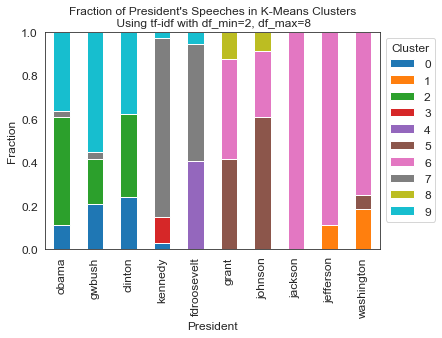

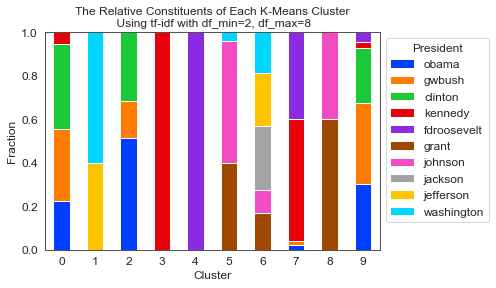

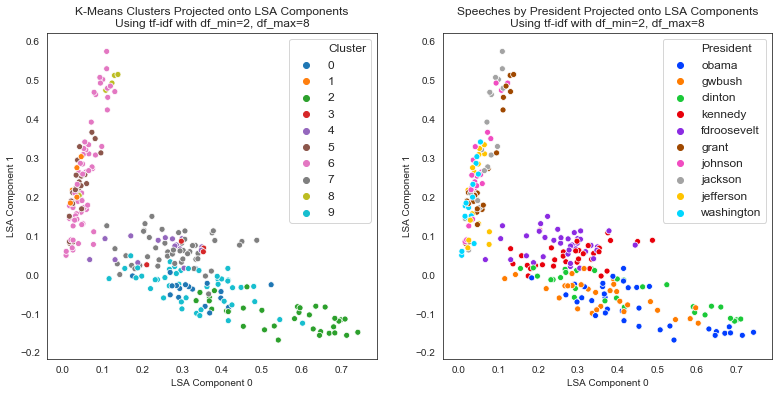

Using tf-idf with df_min=2, df_max=8
ARI score: 0.294 +/- 0.033
completeness score: 0.585 +/- 0.021
homogeneity score: 0.518 +/- 0.027
v-measure score: 0.549 +/- 0.024


In [105]:

# setting the parameters of our tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=8, 
                             # drop words that more than 8 of the presidents say
                             min_df=2, 
                             # only use words that at least two presidents said
                             stop_words='english', 
                             lowercase=True, 
                             # convert everything to lower case 
                             use_idf=True,
                             # we definitely want to use inverse document 
                             # frequencies in our weighting
                             norm='l2', 
                             # we will normalize each row of our document-term 
                             # matrix to have unit length.
                             # Thus, speeches that are longer will not be farther 
                             # from the origin than shorter speeches
                             smooth_idf=True 
                             #Adds 1 to all document frequencies, as if an 
                             #extra document existed that used every word once.  
                             #Prevents divide-by-zero errors
                            )

# fitting the vectorizer to distinguish between the 10 joined speeches for each president:
# we are choosing our features (terms) based on what would be best for determining 
# which president said that term.
# what would be "best" for making this determination is given by our parameter 
# choices of TfidfVectorizer.
vectorizer.fit(president_files_joined)

# with those features we then create the document-term matrix where each row is a single speech
X_tfidf = vectorizer.transform(np.array(df_train['text_']))

# creating the pandas dataframe of this document-term matrix
df_tfidf = pd.DataFrame(X_tfidf.toarray())
df_tfidf.columns = vectorizer.get_feature_names()
df_tfidf['president_'] = df_train['president_']
df_tfidf['text_'] = df_train['text_']

# applying our k_means_analysis function to this document-term matrix
y_true = df_tfidf['president_']
n_clusters = 10
params = {}
description = 'tf-idf with df_min=2, df_max=8'
k_means_analysis(X_tfidf, y_true, n_clusters, params, description)

Right off the bat we see the blob in the bottom right has centered more with each other and created what looks like 2 clusters and maybe 3 depending on how you look at it. But with an ARI of almost 30% and 50% and higher in our completeness, homogeneity, and v-measure, we certainly have a much better model to work with.

Noteworthy features are that the one red spot in kennedy's spot is the only spot there is any red on the first graph, so kennedy is fully clustered. Clusters 3 and 4 on our second graph speak for Kennedy and FDR respectively, meaning we have homogenity in those two clusters. 

We can try this once again with two matrices and see how well it looks.

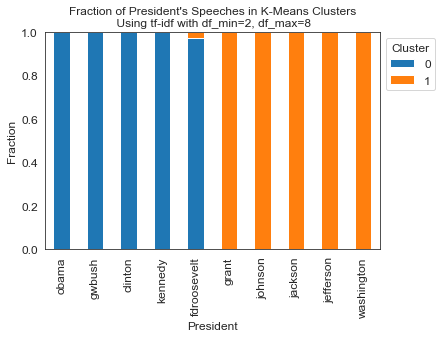

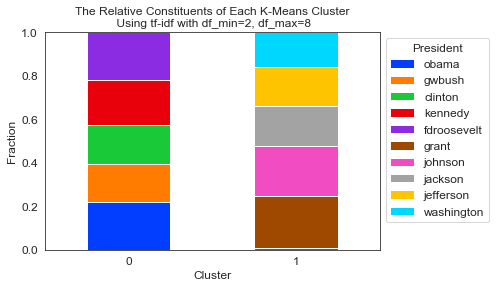

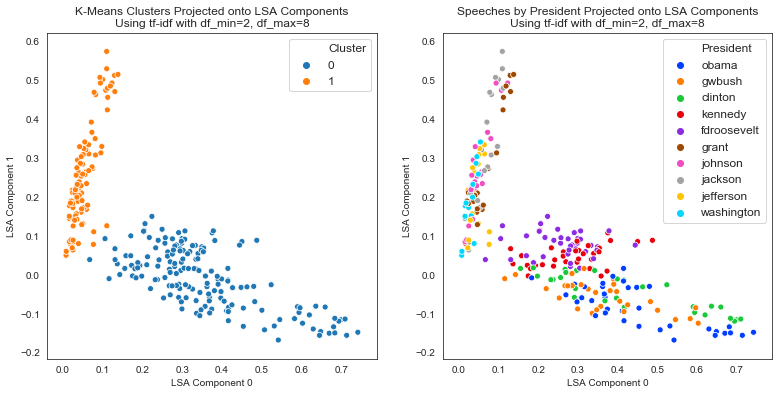

Using tf-idf with df_min=2, df_max=8
ARI score: 0.180 +/- 0.005
completeness score: 0.934 +/- 0.032
homogeneity score: 0.276 +/- 0.008
v-measure score: 0.425 +/- 0.013


In [106]:
n_clusters = 2
params = {}
description = 'tf-idf with df_min=2, df_max=8'
k_means_analysis(X_tfidf, y_true, n_clusters, params, description)

Literally an almost perfect completeness score. Only a few of FDR's speeches are included in the second half, which brings that score down only slightly. 

With the next charts we can see exactly which points are the ones that are being misclassified. Something that might be unnecessary to do, but interesting nonetheless. We will group the first 5 presidents into one era and the second 5 into another era.

The Contingency Table:
president_era_  less_recent  more_recent
row_0                                   
0                         0          164
1                       100            1


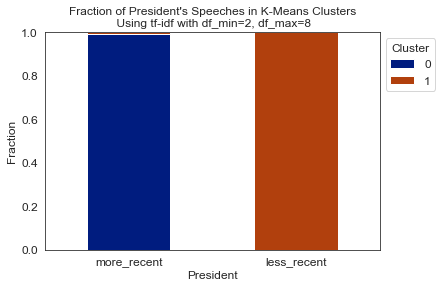

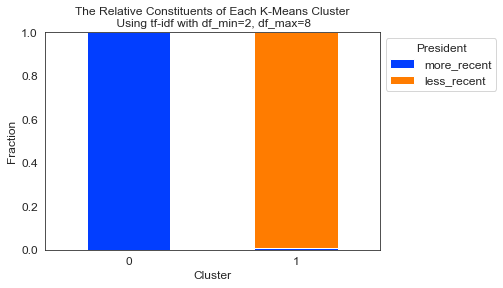

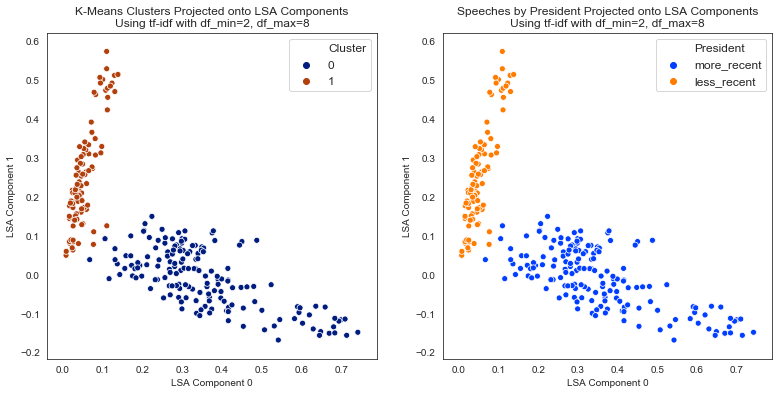

Using tf-idf with df_min=2, df_max=8
ARI score: 0.948 +/- 0.031
completeness score: 0.912 +/- 0.039
homogeneity score: 0.920 +/- 0.035
v-measure score: 0.916 +/- 0.037


In [109]:
df_tfidf['president_era_'] = np.where(
    np.isin(df_tfidf['president_'], 
            ['obama','gwbush','clinton','kennedy','fdroosevelt']),
    'more_recent', 'less_recent')
y_true = df_tfidf['president_era_']

n_clusters = 2
params = {}
description = 'tf-idf with df_min=2, df_max=8'

X = X_tfidf.toarray()

# we will cluster our data ten times and calculate statistics of 
# our metrics for cluster evaluation.
number_of_trials = 10

ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

for trial in range(number_of_trials):

    # we will use scikit-learns MiniBatchKMeans function
    minibatchkmeans = MiniBatchKMeans(
        **params, n_clusters=n_clusters, random_state=trial)
        # this uses the same 10 different random_states each time the code is run)

    # fitting k-means and predicting on our data
    y_pred = minibatchkmeans.fit_predict(X)
    ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
    completeness_scores.append(metrics.completeness_score(y_true, y_pred))
    homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
    v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

# we will print our the score after our plots

# calculating the contigency table for our clustering
# this will be clustering of the last of the trials.
# we have to choose one of the ten clusterings to evaluate.

contigency_table = pd.crosstab(y_pred, y_true)[['more_recent', 'less_recent']]
print("The Contingency Table:")
print(pd.crosstab(y_pred, y_true))

# Normalizing the contigency table. 
# We seek to know the percentage of each presidents speeches in a given cluster.
contigency_table_normalized = pd.DataFrame(
    normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
contigency_table_normalized.columns = ['more_recent', 'less_recent']


# plotting a very similar graph from the transpose of the contingency matrix
# normalizing the crosstab scores so that we can see a given cluster's 
# presidental constituents
crosstab_normalized_T = pd.DataFrame(normalize(
    np.array(contigency_table).T,  axis = 0, norm = 'l1'))
crosstab_normalized_T.columns = range(n_clusters)




# ploting this contigency table as a staked bar plot
sns.set_palette('dark')
ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax3.set(xticklabels = ['more_recent', 'less_recent'])
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.title('Fraction of President\'s Speeches in K-Means Clusters\n Using '
          + str(description), fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.show()

# plotting a presidents cluster breakdown
sns.set_palette('bright')
ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(2))
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(['more_recent','less_recent'], title = 'President',
           title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.title('The Relative Constituents of Each K-Means Cluster\n Using '
          + str(description), fontsize = 12)
plt.show()


# making a two scatter plots of the clusters labeled by predicted cluster and true class. 
# We will plot their projection onto the two primary LSA components.

# creating a data frame with the two LSA components
lsa2 = TruncatedSVD(n_components=2)
X_lsa2 = lsa2.fit_transform(X)
df_lsa2 = pd.DataFrame(X_lsa2)
df_lsa2['y_true'] = y_true
df_lsa2['y_pred'] = y_pred
df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

# plotting the speech along the 2 principal compontents of LSA (Latent Semantic Analysis) 
plt.figure(figsize=(13,6))
sns.set_palette('dark')    
plt.subplot(1, 2, 1)
plt.title('K-Means Clusters Projected onto LSA Components\nUsing '
          + str(description), fontsize = 12)
ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                      palette=['C0', 'C1', 'C2','C3','C4',
                               'C5','C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("Cluster")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

plt.subplot(1, 2, 2)
plt.title('Speeches by President Projected onto LSA Components\nUsing '
          + str(description), fontsize = 12)
ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true',
                      hue_order = ['more_recent', 'less_recent'],
                      palette = 'bright', data = df_lsa2)
legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("President")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')
plt.show()

print('Using {}'.format(description))    
print('ARI score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(ari_scores), 3), 
    round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
print('completeness score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(completeness_scores), 3), 
    round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
print('homogeneity score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(homogeneity_scores), 3), 
    round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
print('v-measure score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(v_measure_scores), 3), 
    round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))

The one point, located at around (0.11,0.11) is the only point that seems to be misclassified, while everything else is classified correctly. Our full list of scores land in the 90s, which is very good for these two clusters. 

Clustering by era was not the goal, but it is good that our model can do at least that with near perfection.

# Using alternate algorithms on our winning tf-idf Matrix

### Mean Shift Algorithm

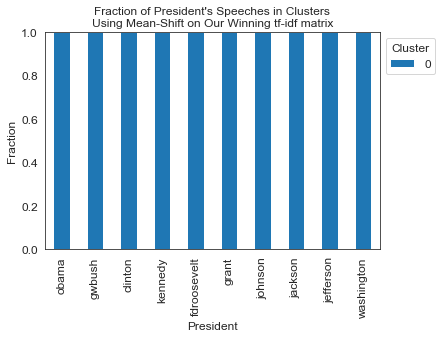

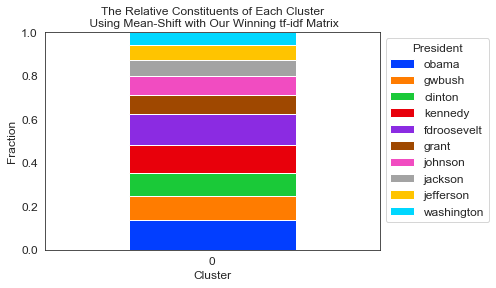

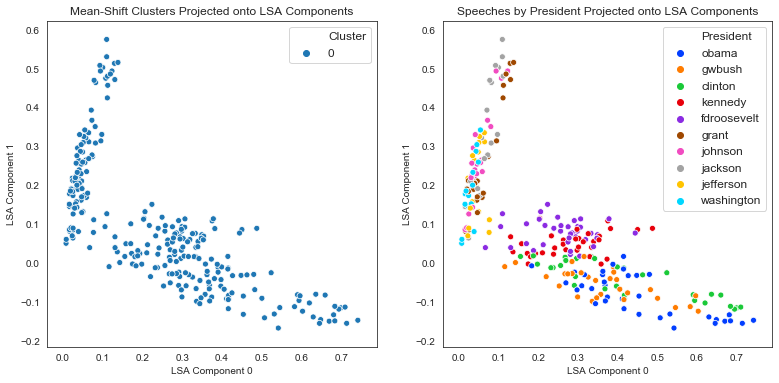

Number of estimated clusters: 1
Using Mean-Shift with Our Winning tf-idf Matrix
ARI score: 0.000 +/- 0.000
completeness score: 1.000 +/- 0.000
homogeneity score: -0.000 +/- 0.000
v-measure score: -0.000 +/- 0.000


In [110]:
# we will cluster our data ten times and calculate statistics of our metrics for cluster evaluation.
number_of_trials = 10


y_true = df_tfidf['president_']

ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

for trial in range(number_of_trials):

    # Here we set the bandwidth. This function automatically derives a bandwidth
    # number based on an inspection of the distances among points in the data.
    bandwidth = estimate_bandwidth(X, quantile = .3)

    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    y_pred = ms.fit_predict(X)

    ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
    completeness_scores.append(metrics.completeness_score(y_true, y_pred))
    homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
    v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

# we will print our the score after our plots

# calculating the contigency table for our clustering
# this will be clustering of the last of the trials.
# we have to choose one of the ten clusterings to evaluate.

contigency_table = pd.crosstab(y_pred, y_true)[presidents]

# Normalizing the contigency table. 
# We seek to know the percentage of each presidents speeches in a given cluster.
contigency_table_normalized = pd.DataFrame(normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
contigency_table_normalized.columns = [presidents]

# Count our clusters.
n_clusters = len(ms.cluster_centers_)

# plotting a very similar graph from the transpose of the contingency matrix
# normalizing the crosstab scores so that we can see a given cluster's presidental constituents
crosstab_normalized_T = pd.DataFrame(normalize(np.array(contigency_table).T,  axis = 0, norm = 'l1'))
crosstab_normalized_T.columns = range(n_clusters)




# ploting this contigency table as a staked bar plot
sns.set_palette('tab10')
ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax3.set(xticklabels = presidents)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Fraction of President\'s Speeches in Clusters\n' +
          'Using Mean-Shift on Our Winning tf-idf matrix', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.show()

# plotting a presidents cluster breakdown
sns.set_palette('bright')
ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(len(presidents)))
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(presidents, title = 'President', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.title('The Relative Constituents of Each Cluster\n Using Mean-Shift with Our Winning tf-idf Matrix', fontsize = 12)
plt.show()


# making a two scatter plots of the clusters labeled by predicted cluster and true class. 
# We will plot their projection onto the two primary LSA components.

# creating a data frame with the two LSA components
lsa2 = TruncatedSVD(n_components=2)
X_lsa2 = lsa2.fit_transform(X)
df_lsa2 = pd.DataFrame(X_lsa2)
df_lsa2['y_true'] = y_true
df_lsa2['y_pred'] = y_pred
df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

# plotting the speech along the 2 principal compontents of LSA (Latent Semantic Analysis) 
plt.figure(figsize=(13,6))
sns.set_palette('tab10')    
plt.subplot(1, 2, 1)
plt.title('Mean-Shift Clusters Projected onto LSA Components', fontsize = 12)
ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                      palette=['C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("Cluster")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

plt.subplot(1, 2, 2)
plt.title('Speeches by President Projected onto LSA Components', fontsize = 12)
ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true', hue_order = presidents, palette = 'bright', data = df_lsa2)
legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("President")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')
plt.show()


print("Number of estimated clusters: {}".format(n_clusters))

print('Using Mean-Shift with Our Winning tf-idf Matrix'.format(description))    
print('ARI score: {:.3f} +/- {:.3f}'.format(round(np.mean(ari_scores), 3),
                                   round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
print('completeness score: {:.3f} +/- {:.3f}'.format(round(np.mean(completeness_scores), 3),
                                   round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
print('homogeneity score: {:.3f} +/- {:.3f}'.format(round(np.mean(homogeneity_scores), 3),
                                   round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
print('v-measure score: {:.3f} +/- {:.3f}'.format(round(np.mean(v_measure_scores), 3),
                                   round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))


An exhaustive search for the quantile parameter for estimate_bandwidth proved fruitless, providing us with a single cluster. Mean-shift algorithm does nothing for this matrix.

### Spectral Clustering

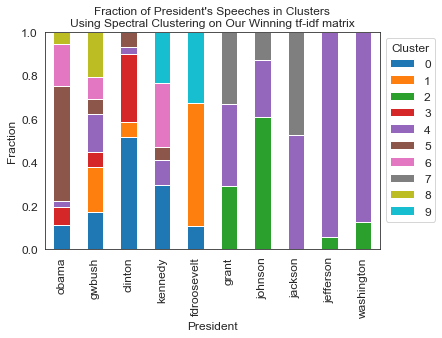

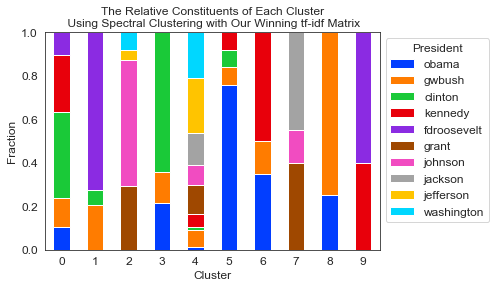

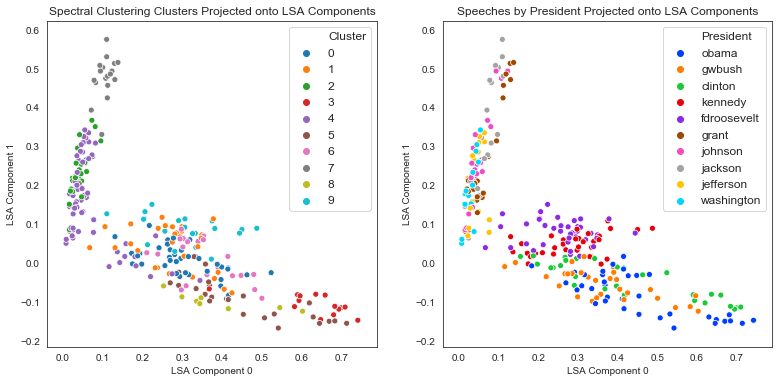

Using Spectral Clustering with Our Winning tf-idf Matrix
ARI score: 0.257 +/- 0.032
completeness score: 0.511 +/- 0.022
homogeneity score: 0.483 +/- 0.019
v-measure score: 0.497 +/- 0.020


In [111]:
X = X_tfidf.toarray()
# we will cluster our data ten times and calculate statistics of our metrics for cluster evaluation.
number_of_trials = 10

# We know we're looking for three clusters.
n_clusters=10

ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

for trial in range(number_of_trials):

    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=n_clusters, random_state=trial)
    
    #Predicted clusters.
    y_pred = sc.fit_predict(X)

    ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
    completeness_scores.append(metrics.completeness_score(y_true, y_pred))
    homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
    v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

# we will print our the score after our plots

# calculating the contigency table for our clustering
# this will be clustering of the last of the trials.
# we have to choose one of the ten clusterings to evaluate.

contigency_table = pd.crosstab(y_pred, y_true)[presidents]

# Normalizing the contigency table. 
# We seek to know the percentage of each presidents speeches in a given cluster.
contigency_table_normalized = pd.DataFrame(normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
contigency_table_normalized.columns = [presidents]


# plotting a very similar graph from the transpose of the contingency matrix
# normalizing the crosstab scores so that we can see a given cluster's presidental constituents
crosstab_normalized_T = pd.DataFrame(normalize(np.array(contigency_table).T,  axis = 0, norm = 'l1'))
crosstab_normalized_T.columns = range(n_clusters)




# ploting this contigency table as a staked bar plot
sns.set_palette('tab10')
ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax3.set(xticklabels = presidents)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Fraction of President\'s Speeches in Clusters\n' +
          'Using Spectral Clustering on Our Winning tf-idf matrix', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.show()

# plotting a presidents cluster breakdown
sns.set_palette('bright')
ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(len(presidents)))
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(presidents, title = 'President', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.title('The Relative Constituents of Each Cluster\n Using Spectral Clustering with Our Winning tf-idf Matrix', fontsize = 12)
plt.show()


# making a two scatter plots of the clusters labeled by predicted cluster and true class. 
# We will plot their projection onto the two primary LSA components.

# creating a data frame with the two LSA components
lsa2 = TruncatedSVD(n_components=2)
X_lsa2 = lsa2.fit_transform(X)
df_lsa2 = pd.DataFrame(X_lsa2)
df_lsa2['y_true'] = y_true
df_lsa2['y_pred'] = y_pred
df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

# plotting the speech along the 2 principal compontents of LSA (Latent Semantic Analysis) 
plt.figure(figsize=(13,6))
sns.set_palette('tab10')    
plt.subplot(1, 2, 1)
plt.title('Spectral Clustering Clusters Projected onto LSA Components', fontsize = 12)
ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                      palette=['C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("Cluster")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

plt.subplot(1, 2, 2)
plt.title('Speeches by President Projected onto LSA Components', fontsize = 12)
ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true', hue_order = presidents, palette = 'bright', data = df_lsa2)
legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("President")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')
plt.show()


print('Using Spectral Clustering with Our Winning tf-idf Matrix'.format(description))    
print('ARI score: {:.3f} +/- {:.3f}'.format(round(np.mean(ari_scores), 3),
                                   round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
print('completeness score: {:.3f} +/- {:.3f}'.format(round(np.mean(completeness_scores), 3),
                                   round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
print('homogeneity score: {:.3f} +/- {:.3f}'.format(round(np.mean(homogeneity_scores), 3),
                                   round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
print('v-measure score: {:.3f} +/- {:.3f}'.format(round(np.mean(v_measure_scores), 3),
                                   round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))


This algorithm just does about the same job of clustering by president that k-means does. The score is almost exactly the same as one of our earlier iterations and better than a lot of other iterations.

### Affinity Propagation

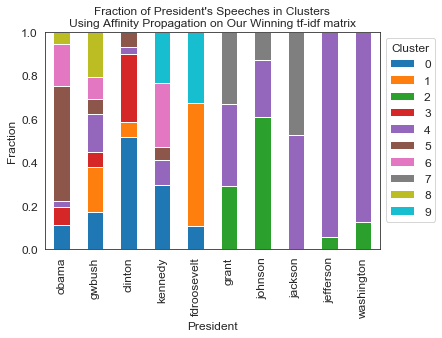

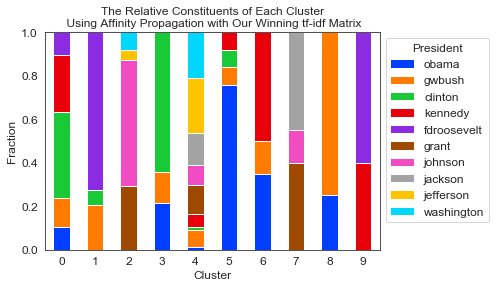

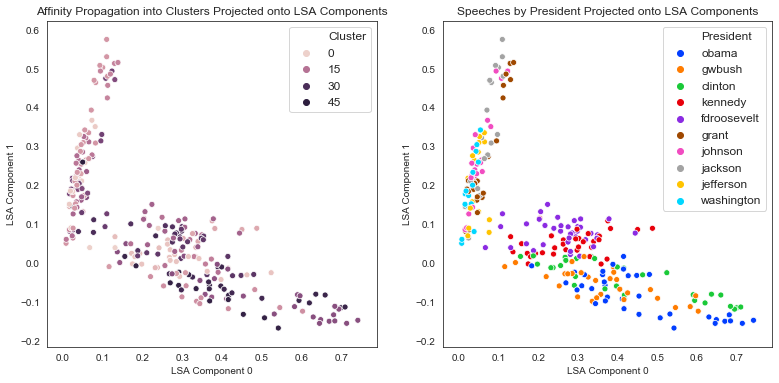

Affinity Propagation's estimated number of clusters: 10
Using Affinity Propagation with Our Winning tf-idf Matrix
ARI score: 0.244
completeness score: 0.491
homogeneity score: 0.718
v-measure score: 0.584


In [124]:
X = X_tfidf.toarray()
# we will cluster our data ten times and calculate statistics of our metrics for cluster evaluation.
number_of_trials = 10

# the Affinity Propogation Algorithm will produce the same output each time it is run.
# Thus, there is no need from trials.
# We will use the previous code for convinience, but not there is only one score we are taking the mean of.
ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

    
# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation()

y_pred = af.fit_predict(X)

ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
completeness_scores.append(metrics.completeness_score(y_true, y_pred))
homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

# plotting this contigency table as a staked bar plot
sns.set_palette('tab10')
ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax3.set(xticklabels = presidents)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Fraction of President\'s Speeches in Clusters\n' +
          'Using Affinity Propagation on Our Winning tf-idf matrix', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.show()

# plotting a presidents cluster breakdown
sns.set_palette('bright')
ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(len(presidents)))
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(presidents, title = 'President', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.title('The Relative Constituents of Each Cluster\n Using Affinity Propagation with Our Winning tf-idf Matrix', fontsize = 12)
plt.show()

# making a two scatter plots of the clusters labeled by predicted cluster and true class. 
# We will plot their projection onto the two primary LSA components.

# creating a data frame with the two LSA components
lsa2 = TruncatedSVD(n_components=2)
X_lsa2 = lsa2.fit_transform(X)
df_lsa2 = pd.DataFrame(X_lsa2)
df_lsa2['y_true'] = y_true
df_lsa2['y_pred'] = y_pred
df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

# plotting the speech along the 2 principal compontents of LSA (Latent Semantic Analysis) 
plt.figure(figsize=(13,6))
sns.set_palette('tab10')    
plt.subplot(1, 2, 1)
plt.title('Affinity Propagation into Clusters Projected onto LSA Components', fontsize = 12)
ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', data = df_lsa2)
legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("Cluster")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

plt.subplot(1, 2, 2)
plt.title('Speeches by President Projected onto LSA Components', fontsize = 12)
ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true', hue_order = presidents, palette = 'bright', data = df_lsa2)
legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("President")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')
plt.show()

print('Affinity Propagation\'s estimated number of clusters: {}'.format(n_clusters))

print('Using Affinity Propagation with Our Winning tf-idf Matrix'.format(description))    
print('ARI score: {:.3f}'.format(round(np.mean(ari_scores), 3)))
print('completeness score: {:.3f}'.format(round(np.mean(completeness_scores), 3)))
print('homogeneity score: {:.3f}'.format(round(np.mean(homogeneity_scores), 3)))
print('v-measure score: {:.3f}'.format(round(np.mean(v_measure_scores), 3)))


This algorithm has a single output, so only one trial is necessary. From the scores we got, it again does a fair job at clustering the data by president. The ARI is 24%, just about average of the scores we've gotten. Homogeneity is extremely high though, compared to our other values. But that does not help our clustering much at all.

# Optimizing Clustering

K-means remains to be the best clustering algorithm for the data we chose. But, we did use k-means to determine the best matrix. Perhaps if we used another algorithm to determine the best matrix, that algorithm would be best used to cluster as well. For larger amounts of words from BoW, we could use an algorithm that deals better with that many words. Or perhaps other algorithms would do better with different scalings. Regardless, for the project at hand, we have the optimal features and clustering methods here. Many other projects can be tackled for other algorithms.

We succeeded in clustering by two clusters for separate eras, but the goal of clustering by president seems to be still to be desired. I'm sure other methods are out there to tackle this, but this one is not it. Now if we are using this to cluster by era, our model does an amazing job of that -- a near 100% ARI score. But we should attempt to run our algorithm on the test data to see where we really stand with this.

## Using our winning model on the test data

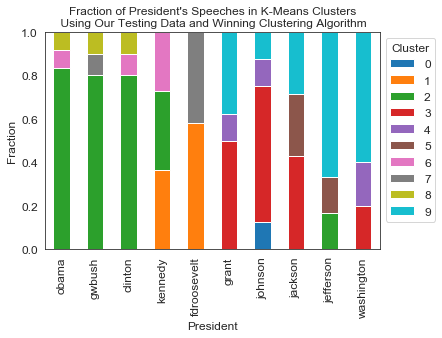

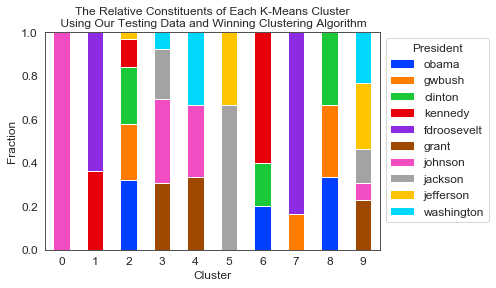

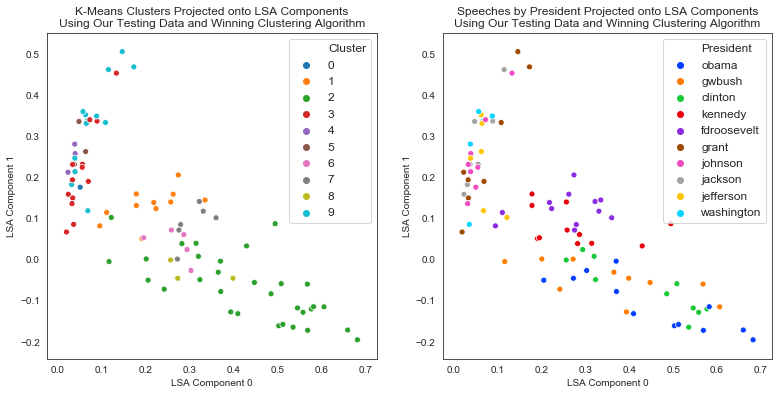

Using Our Testing Data and Winning Clustering Algorithm
ARI score: 0.223 +/- 0.035
completeness score: 0.584 +/- 0.027
homogeneity score: 0.469 +/- 0.031
v-measure score: 0.519 +/- 0.028


In [125]:
# This code is copied.
# setting the parameters of our tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=8, 
                             # drop words that more than 8 of the presidents say
                             min_df=2, 
                             # only use words that at least two presidents said
                             stop_words='english', 
                             lowercase=True, 
                             # convert everything to lower case 
                             use_idf=True,
                             # we definitely want to use inverse document 
                             # frequencies in our weighting
                             norm='l2', 
                             # we will normalize each row of our document-term 
                             # matrix to have unit length.
                             # Thus, speeches that are longer will not be farther 
                             # from the origin than shorter speeches
                             smooth_idf=True 
                             #Adds 1 to all document frequencies, as if an 
                             #extra document existed that used every word once.  
                             #Prevents divide-by-zero errors
                            )


# fitting the vectorizer to distinguish between the 10 joined speeches 
# for each president:
# we fit the vecorizer on the training data
vectorizer.fit(president_files_joined)

# Now we involve the testing data.
# We use the features the vectorizer chose when 
# fitting to the training data, and transform the testing data.
X_tfidf_test = vectorizer.transform(np.array(df_test['text_']))

# creating the pandas dataframe of this document-term matrix
df_tfidf_test = pd.DataFrame(X_tfidf_test.toarray())
df_tfidf_test.columns = vectorizer.get_feature_names()
df_tfidf_test['president_'] = df_test['president_']
df_tfidf_test['text_'] = df_test['text_']

# applying our k_means_analysis function to this document-term matrix
y_true_test = df_tfidf_test['president_']
n_clusters = 10
params = {}
description = 'Our Testing Data and Winning Clustering Algorithm'
k_means_analysis(X_tfidf_test, y_true_test, n_clusters, params, description)

Unfortunately it did not perform well on this data either, but again, it's similar to what we had in previous iterations of the data. Lower than the highest ARI score we could achieve with the training data, but decent completeness and homogeneity scores which are about on par with what we had previously. 

The clustering looks to be semi-stable. The fact that our scores are very close to one another goes to show that we have a somewhat stable model, but with much room to improve.

The bar graphs are again very similar to what we had and the scatterplots have pretty clear clusters. 

Again, let's try to run the model with clustering by the two eras to see how well it does.

The Contingency Table:
president_era_  less_recent  more_recent
row_0                                   
0                         1           54
1                        33            1


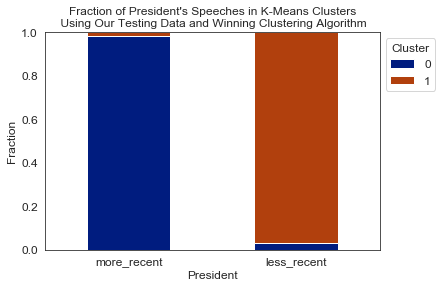

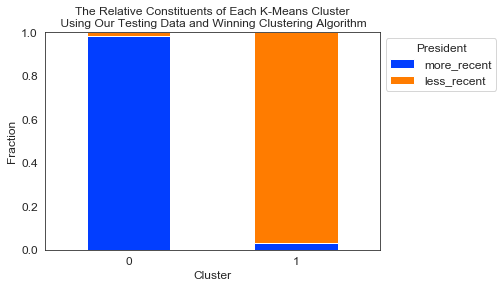

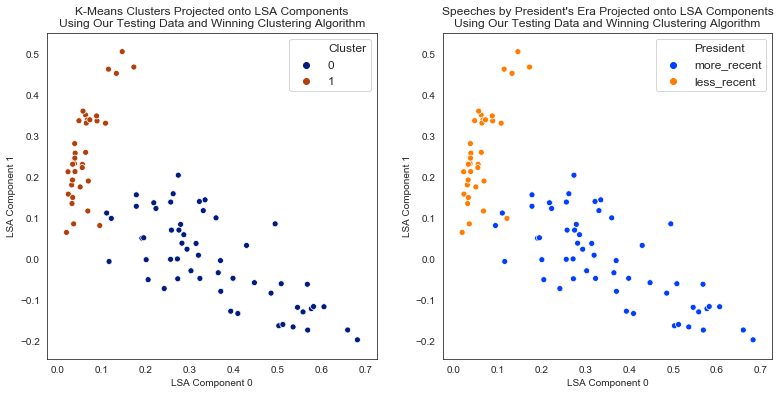

Using Our Testing Data and Winning Clustering Algorithm
ARI score: 0.881 +/- 0.047
completeness score: 0.879 +/- 0.040
homogeneity score: 0.880 +/- 0.040
v-measure score: 0.879 +/- 0.040


In [126]:
df_tfidf_test['president_era_'] = np.where(
    np.isin(df_tfidf_test['president_'], 
            ['obama','gwbush','clinton','kennedy','fdroosevelt']),
    'more_recent', 'less_recent')
y_true = df_tfidf_test['president_era_']

n_clusters = 2
params = {}
description = 'Our Testing Data and Winning Clustering Algorithm'

X = X_tfidf_test.toarray()

# we will cluster our data ten times and calculate statistics 
# of our metrics for cluster evaluation.
number_of_trials = 100

ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

for trial in range(number_of_trials):

    # we will use scikit-learns MiniBatchKMeans function
    minibatchkmeans = MiniBatchKMeans(
        **params, n_clusters=n_clusters, random_state=trial)
        # this uses the same 10 different random_states each time the code is run)

    # fitting k-means and predicting on our data
    y_pred = minibatchkmeans.fit_predict(X)
    ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
    completeness_scores.append(metrics.completeness_score(y_true, y_pred))
    homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
    v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

# we will print our the score after our plots

# calculating the contigency table for our clustering
# this will be clustering of the last of the trials.
# we have to choose one of the ten clusterings to evaluate.

contigency_table = pd.crosstab(y_pred, y_true)[['more_recent', 'less_recent']]
print("The Contingency Table:")
print(pd.crosstab(y_pred, y_true))

# Normalizing the contigency table. 
# We seek to know the percentage of each presidents speeches in a given cluster.
contigency_table_normalized = pd.DataFrame(
    normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
contigency_table_normalized.columns = ['more_recent', 'less_recent']


# plotting a very similar graph from the transpose of the contingency matrix
# normalizing the crosstab scores so that we can see a given cluster's 
# presidental constituents
crosstab_normalized_T = pd.DataFrame(
    normalize(np.array(contigency_table).T,  axis = 0, norm = 'l1'))
crosstab_normalized_T.columns = range(n_clusters)




# ploting this contigency table as a staked bar plot
sns.set_palette('dark')
ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax3.set(xticklabels = ['more_recent', 'less_recent'])
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.title('Fraction of President\'s Speeches in K-Means Clusters\n Using '
          + str(description), fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1),
           prop={'size': 12})
plt.ylim(0,1)
plt.show()

# plotting a presidents cluster breakdown
sns.set_palette('bright')
ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(2))
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(['more_recent','less_recent'], title = 'President',
           title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.title('The Relative Constituents of Each K-Means Cluster\n Using '
          + str(description), fontsize = 12)
plt.show()


# making a two scatter plots of the clusters labeled by predicted cluster and true class. 
# We will plot their projection onto the two primary LSA components.

# creating a data frame with the two LSA components
lsa2 = TruncatedSVD(n_components=2)
X_lsa2 = lsa2.fit_transform(X)
df_lsa2 = pd.DataFrame(X_lsa2)
df_lsa2['y_true'] = y_true
df_lsa2['y_pred'] = y_pred
df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

# plotting the speech along the 2 principal compontents of LSA (Latent Semantic Analysis) 
plt.figure(figsize=(13,6))
sns.set_palette('dark')    
plt.subplot(1, 2, 1)
plt.title('K-Means Clusters Projected onto LSA Components\nUsing '
          + str(description), fontsize = 12)
ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                      palette=['C0', 'C1', 'C2','C3','C4',
                               'C5','C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("Cluster")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

plt.subplot(1, 2, 2)
plt.title('Speeches by President\'s Era Projected onto LSA Components\nUsing '
          + str(description), fontsize = 12)
ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true',
                      hue_order = ['more_recent', 'less_recent'], palette = 'bright',
                      data = df_lsa2)
legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("President")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')
plt.show()

print('Using {}'.format(description))    
print('ARI score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(ari_scores), 3),
    round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
print('completeness score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(completeness_scores), 3),
    round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
print('homogeneity score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(homogeneity_scores), 3),
    round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
print('v-measure score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(v_measure_scores), 3),
    round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))


About an 88% ARI score with very high scores all around shows that it's extremely close to clustering this perfectly. Now there does seem to be a few points that don't get classified perfectly, but the scores remain extremely similar to the clustering by era in the training set. All in all, it stays consistent.

# Conclusion on Clustering Test Data

The algorithm does not perform as well on the testing data as it does on the training, but that doesn't mean that our algorithm isn't stable. The fact it keeps a consistent score throughout the training and testing process shows there is some merit to it, But perhaps if we had more datapoints we would be able to create a more stable model. There were 354 speeches so our training data had a smaller amount than desired. Common trends may not have been detected in training sets, therefore unable to be detected in the test set. The more speeches that are done would provide more of an insight to us, especially considering President Trump and his extremely distinct way of speaking. Once his speeches are added to a corpus of sorts, we might consider revisiting this topic and see how it affects our model. Or try to run new models to see what could potentially do better.

Our algorithm does however successfully cluster by era in the test set. There are two very visible clusters that we can observe, showing the algorithm can detect differences in speech between the two different eras.

Now, using supervised learning, we can see if it performs better on this dataset. We can use the tf-idf matrix and see how well supervised learning methods do at classifying our data

# Supervised Learning

## KNN

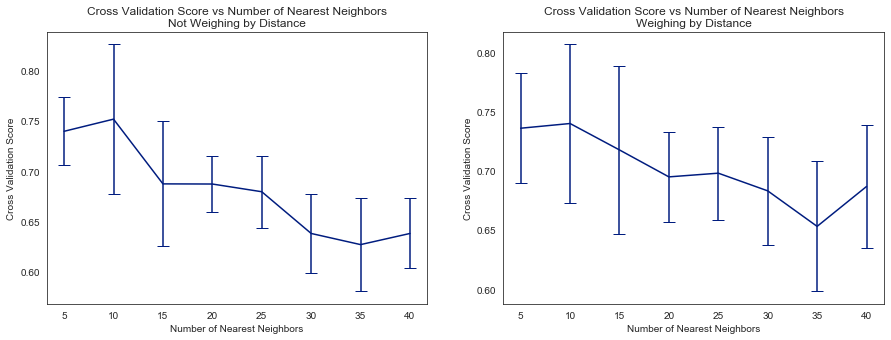

In [127]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = [5,10,15,20,25,30,35,40]
mean_scores = []
sigma2_scores = []

for value in values: 
    neighbors = KNeighborsClassifier(n_neighbors=value)
    cross_score = cross_val_score(neighbors, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

    
# Plotting the two figures.    
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Nearest Neighbors\nNot Weighing by Distance')
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross Validation Score')


# weighing by distance

mean_scores = []
sigma2_scores = []
params = {'weights':'distance'}
for value in values: 
    neighbors = KNeighborsClassifier(n_neighbors=value, **params)
    cross_score = cross_val_score(neighbors, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))


plt.subplot(1, 2, 2)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Nearest Neighbors\nWeighing by Distance')
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross Validation Score')
plt.show()

Our CV scores are doing very well using KNN. This data now seems to be very clearly suited for supervised learning. The scores are higher the lower the neighbors there are, so instead, let's run the algorithm instead with a fewer amount of neighbors, which makes sense given that each president has maybe 30 speeches at maximum.

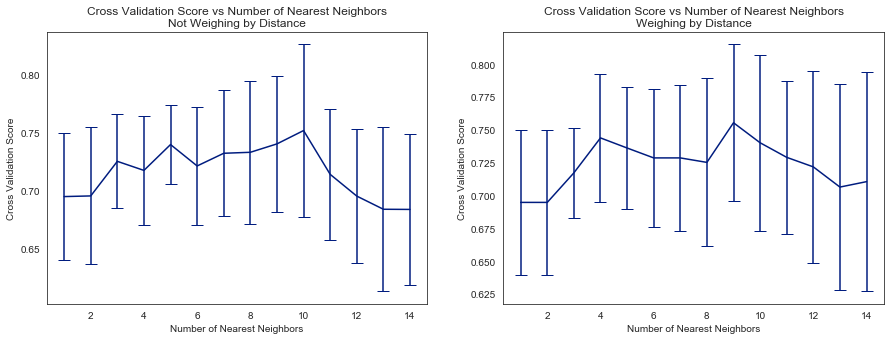

In [129]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = list(range(1,15))
mean_scores = []
sigma2_scores = []

for value in values: 
    neighbors = KNeighborsClassifier(n_neighbors=value)
    cross_score = cross_val_score(neighbors, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

    
# Plotting the two figures.    
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Nearest Neighbors\nNot Weighing by Distance')
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross Validation Score')


# weighing by distance

mean_scores = []
sigma2_scores = []
params = {'weights':'distance'}
for value in values: 
    neighbors = KNeighborsClassifier(n_neighbors=value, **params)
    cross_score = cross_val_score(neighbors, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))


plt.subplot(1, 2, 2)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Nearest Neighbors\nWeighing by Distance')
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross Validation Score')
plt.show()

Both weighting with and without distance have spikes of CV scores at about 5 and 10 neighbors. The CV score reaches its highest around 75% which is quite good!

## Random Forest

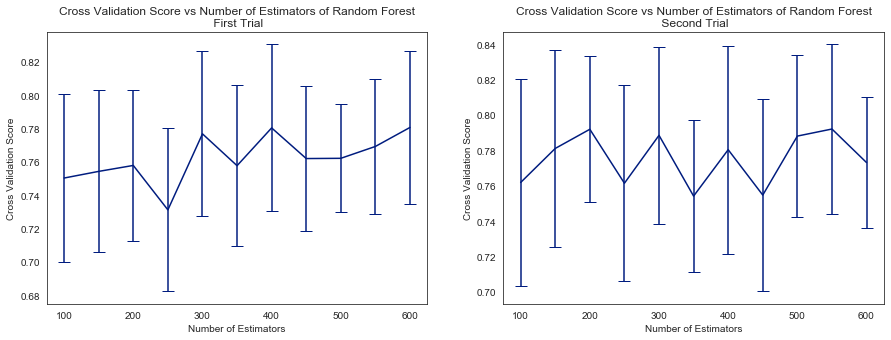

In [130]:
y = df_tfidf['president_']
values = [100,150,200,250,300,350,400,450,500,550,600]
params = {}
mean_scores = []
sigma2_scores = []

for value in values: 
    rfc = ensemble.RandomForestClassifier(n_estimators=value, **params)
    cross_score = cross_val_score(rfc, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

# Plotting the two figures.    
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Estimators of Random Forest\n First Trial')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Score')

mean_scores = []
sigma2_scores = []

for value in values: 
    rfc = ensemble.RandomForestClassifier(n_estimators=value, **params)
    cross_score = cross_val_score(rfc, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))
    
plt.subplot(1, 2, 2)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Estimators of Random Forest\n Second Trial')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Score')
plt.show()

Random Forest performs even better as a classifier. The CV scores go almost as high as 80%.

## Logistic Regression

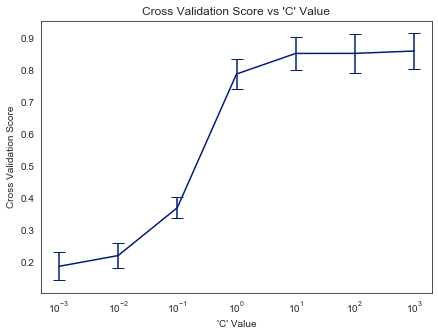

In [131]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = [.001, .01, .1, 1, 10, 100, 1000]
params = {'multi_class':'auto', 'solver':'lbfgs'}
mean_scores = []
sigma2_scores = []

for value in values: 
    lr = LogisticRegression(C=value, **params)
    cross_score = cross_val_score(lr, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

plt.figure(figsize=(7,5))
plt.xscale('log')
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs \'C\' Value')
plt.xlabel('\'C\' Value')
plt.ylabel('Cross Validation Score')
plt.show()

Larger C values is absolutely the best choice for this model. Let's observe larger C values alone in a plot

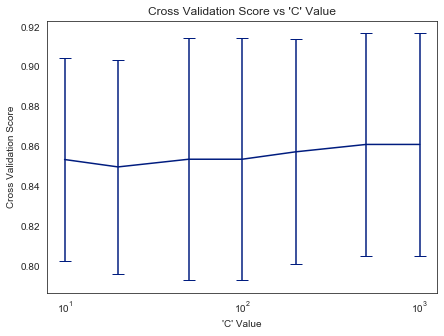

In [132]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = [10, 20, 50, 100, 200, 500, 1000]
params = {'multi_class':'auto', 'solver':'lbfgs'} # updated default parameters
mean_scores = []
sigma2_scores = []

for value in values: 
    lr = LogisticRegression(C=value, **params)
    cross_score = cross_val_score(lr, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

plt.figure(figsize=(7,5))
plt.xscale('log')
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs \'C\' Value')
plt.xlabel('\'C\' Value')
plt.ylabel('Cross Validation Score')
plt.show()

So the values level off around 85%, so we can use that as our score. This is definitely the best classifier yet.

## Support Vector Machine

In [134]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
svclf = SVC(kernel='linear') # using the a linear kernel
cross_score = cross_val_score(svclf, X, y, cv=10)
print('cross validation score = '+ str(round(cross_score.mean(),6)) +' +/- ' + str(round(cross_score.std()*2/np.sqrt(len(cross_score)),6)))

cross validation score = 0.819658 +/- 0.052029


Score for the SVM returns quite a good score as well, but not quite as well as the regression model.

## Gradient Boosting Classifier

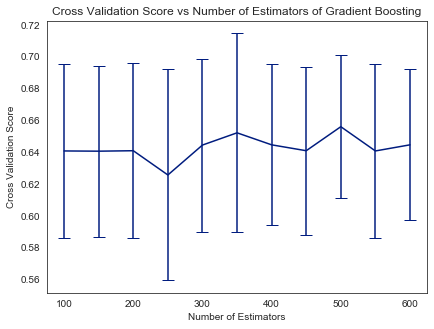

In [139]:
y = df_tfidf['president_']
values = [100,150,200,250,300,350,400,450,500,550,600]
params = {}
mean_scores = []
sigma2_scores = []

for value in values: 
    gbc = GradientBoostingClassifier(n_estimators = value, **params)
    cross_score = cross_val_score(gbc, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

# Plotting the two figures.    
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Estimators of Gradient Boosting')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Score')
plt.show()

The GB classifier ends up not being optimal, roughly scoring in the 60% range.

## Optimal Classifier: Logistic Regression

In [136]:
# calculating the score statistics for our winning classifier:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
params = {'multi_class':'auto', 'solver':'lbfgs'}
lr = LogisticRegression(C=200, **params)
cross_score = cross_val_score(lr, X, y, cv=10)
print('cross validation score = '+ str(round(cross_score.mean(),6)) +' +/- ' + str(round(cross_score.std()*2/np.sqrt(len(cross_score)),6)))

cross validation score = 0.857407 +/- 0.056303


## Using Optimal Classifier on Test data

In [137]:
# our testing and training input data
X_train = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
X_test = df_tfidf_test.drop(['text_', 'president_era_', 'president_'], 1)

# our models target to train on and testing target
y_train = df_tfidf['president_']
y_test_true = df_tfidf_test['president_']

# our winning model
params = {'multi_class':'auto', 'solver':'lbfgs'}
lr = LogisticRegression(C=200, **params)

# fitting to the training data and prediction the testing data
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

# our evaluation metrics
cf = confusion_matrix(y_test_true, y_test_pred, labels=presidents)
pd.DataFrame(cf)
print('We have achieved an accuracy score of {}%.'.format(100*round(accuracy_score(y_test_true, y_test_pred), 3)))

# formating the pandas dataframe which shows our confusion matrix
d = dict(selector="th",
    props=[('text-align', 'center')])

# printing our results
print('Our Confusion Matrix:\n(The rows are the true labels. The columns are our model\'s predictions)')
pd.DataFrame(cf, columns=presidents, index=presidents).style.set_properties(**{'width':'6em', 'text-align':'center'})\
        .set_table_styles([d])

We have achieved an accuracy score of 85.39999999999999%.
Our Confusion Matrix:
(The rows are the true labels. The columns are our model's predictions)


,obama,gwbush,clinton,kennedy,fdroosevelt,grant,johnson,jackson,jefferson,washington
obama,10,0,2,0,0,0,0,0,0,0
gwbush,1,8,1,0,0,0,0,0,0,0
clinton,1,0,8,1,0,0,0,0,0,0
kennedy,0,0,0,11,0,0,0,0,0,0
fdroosevelt,0,0,0,0,12,0,0,0,0,0
grant,0,0,0,0,0,6,2,0,0,0
johnson,0,0,0,0,0,0,7,0,1,0
jackson,0,0,0,0,0,0,0,5,0,2
jefferson,0,0,0,0,0,1,0,0,5,0
washington,0,0,0,0,0,0,0,1,0,4


In our holdout group, the Logistic Regression model did a great job predicting the outcome. The model predicted 85.4% of instances correctly. This is considerably high considering we have 10 classes. In our confusion matrix, we see very few counts anywhere but the diagonal, which is exactly what we want to see. And where the classifier got the prediction wrong, it still chose a president within the same era.

Which begs to show how the confusion matrix for our holdout group looks in terms of classification by presidential era

In [138]:
X_train = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
X_test = df_tfidf_test.drop(['text_', 'president_era_', 'president_'], 1)

y_train = df_tfidf['president_era_']
y_test_true = df_tfidf_test['president_era_']

params = {'multi_class':'auto', 'solver':'lbfgs'}
lr = LogisticRegression(C=200, **params)

lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

cf = confusion_matrix(y_test_true, y_test_pred, labels=['more_recent', 'less_recent'])
pd.DataFrame(cf)
print('When predicting by era, we have achieved an accuracy score of {}%.'.format(
    100*round(accuracy_score(y_test_true, y_test_pred), 3)))

d = dict(selector="th",
    props=[('text-align', 'center')])

print('Our President Era Confusion Matrix:\n(The rows are the true labels.\
The columns are our model\'s predictions)')
pd.DataFrame(cf, columns=['more_recent', 'less_recent'],
             index=['more_recent', 'less_recent']).style.set_properties(**{'width':'6em', 'text-align':'center'})\
        .set_table_styles([d])

When predicting by era, we have achieved an accuracy score of 100.0%.
Our President Era Confusion Matrix:
(The rows are the true labels.The columns are our model's predictions)


,more_recent,less_recent
more_recent,55,0
less_recent,0,34


And we have a prediction accuracy of 100%. This is much simpler of course than the 10 classes to place data into, but still impressive nonetheless.

# Conclusion

While we did try multiple combinations of Bag of Words, LSA components, multiple types of scaling, and tf-idf features alongside multiple algorithms, we were not able to achieve our goal -- cluster speeches well by president. But along the way we realized just how well it was clustering by era. The best we were able to achieve was around 26% clustering accuracy, which is certainly better than none. When we performed clustering by era, we ended up with extremely high ARI scores pushing high 80's and 90s. Though that wasn't our goal, it was nice to see where our model could help.

Then instead of trying to cluster our data, we moved onto applying supervised learning methods to attempt to classify rather than cluster, which turned out was the better option. 85% accuracy is certainly amazing for our Logistic Regression Classifier.

I believe it would be even more interesting to use all the presidents to see how well things could be clustered or classified when taken in terms of perhaps centuries or some period of time versus others since that was the strongest point of our classifiers and clustering methods. 

We then could also consider using other methods with spaCy, specifically determining what parts of speech certain words are used in most places by certain presidents. Or maybe even including very commonly used words per president and using that as a determining factor instead of factoring words per speech. I would love to see more projects like this taking word count and verbage used as a feature as well.

The findings we have here could possibly help linguists or those who study language determine what things about these different eras cause such a distinct divide in speech. Specifically older presidents, since they were clustered so closely, must have had very similar speaking, whereas the more recent presidents were more scattered on each of the plots we had. 

These findings can only get more intricate as we have more presidents with more speeches and ways of speaking. We could certainly revisit some more information releases on our future presidents and run calculations again using different facets.